# Lorenz System

References to the NOTES section are written as [0].

## Table of Contents

SETUP

---

Library imports and the implementation of 3D drawing tools.

PROBLEM STATEMENT

---

Differential equations and questions.

SOLUTION

---

1. **Constants.**
2. **Calculation Functions.**
3. **General Plot Functions.** Functions for plotting eigenvalues, bifurcation diagrams, trajectories ...
4. **Plot Setup.** Settings for figures in the ANSWERS section.
5. **Specific Plot Functions.** Functions for making figures in the ANSWERS section.
6. **Plot Decoration.** Figure labels, highlights ...
7. **Widgets.**

ANSWERS

---

Figures and answers to the questions posed in the PROBLEM STATEMENT section.

EPILOGUE

---

1. **Chaos.** Additional figures and information.
2. **Numerical Computation.**

NOTES

---

Additional information and remarks.

## Setup

In [1]:
# Google Colab does not have with ipympl installed. This doesn't allow for
# interactive figures. Uncomment the following code if you wish to run this
# notebook in Google Colab.

'''

!pip install -q ipympl

from google.colab import output
output.enable_custom_widget_manager()

'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00


In [2]:
# If figures aren't showing, try %matplotlib notebook
%matplotlib widget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from matplotlib.text import Annotation
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

from ipywidgets import widgets, Layout, Label, HBox, VBox

# Larger output windows
from IPython.display import Javascript

# When lots of figures are opened, Google Colab gives a Runtimewarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

The following cell implements some extra 3D drawing tools. Credit to *WetHat* on Github [1].

In [3]:
class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)


class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)
    return annotation

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add a 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
    return arrow

setattr(Axes3D, 'annotate3D', _annotate3D)
setattr(Axes3D, 'arrow3D', _arrow3D)

## Problem Statement

The following set of differential equations model *atmospheric convection*.

$X' = \sigma (Y - X)$

$Y' = X (\rho - Z) - Y$

$Z' = XY - \beta Z$

with $\sigma, \beta, \rho > 0$ parameters of the system. $X$ is proportional to the rate of convection, $Y$ to the horizontal temperature variation, and $Z$ the vertical temperature variation. For this exercise $\sigma = 10$ and $\beta = 8/3$, while $\rho$ will be varied.

**Question 1:** What behavior does the system show for $\rho < 1$? Compute the number of equilibria, the stability of the equilibria via the Jacobian matrix and show with a 3D plot (add arrows to your plot).

**Question 2:** Now vary $\rho$ so it passes 1. What type of bifurcation do you see? Explain with the eigenvalues.

**Question 3:** Continue this analysis until $\rho = 28$. Make a plot with $(\rho, X)$, $(\rho, Y)$ and $(\rho, Z)$ where you show the different equilibria and its type (stable versus unstable).

**Question 4:** Show some figures where you plot $X(t)$, $Y(t)$, $Z(t)$ around the value of $\rho = 24.06$ (set $\rho = 22.05$ and $\rho = 25$). What do you see? Be aware that your results should not depend on your integration parameter $dt$! Also show that your stable points are in fact stable. What do you notice?

**Question 5:** For $\rho = 24.06$ you will find a chaotic attractor. Let us have a closer look at this attractor. Plot $Z$ as a function of $Y$ for a range of time, so you can see that the solution just leaves one side of the attractor and then goes to the other side of the attractor. What qualitative behavior do you observe in terms of switching the wings of the attractor? Think of a nice way to show this behavior.

**Question 6:** Focus on is $Z_n$, the $n$-th local maximum of $Z(t)$. (Plot $Z$ as a function of time to see this). Lorenz's idea is that $Z_n$ should predict $Z_{n+1}$. Prove this.

**Question 7:** Extra points: Show in 2 different ways that this system is not random, but chaotic.

## Solution

EQUILIBRIA

We can see off the bat that the origin $(X, Y, Z) = (0, 0, 0)$ is an equilibrium (the gradient vanishes). The other 2 equilibria were calculated as followed.

From the equation for $X'$ we can immediately deduce that $X = Y$, since $\sigma \neq 0$. We then find $Z = \rho - 1$ from the equation for $Y'$. Finally, from the equation for $Z'$ we find 2 roots for $X = Y$. We obtain the following equilibria.

$(X, Y, Z) = (0, 0, 0)$

$(X, Y, Z) = (\sqrt{\beta (\rho - 1)}, \sqrt{\beta (\rho - 1)}, \rho - 1)$

$(X, Y, Z) = (-\sqrt{\beta (\rho - 1)}, -\sqrt{\beta (\rho - 1)}, \rho - 1)$

From now on, we will refer to (0, 0, 0) as the origin equilibrium. The second equilibrium will be the equilibrium $X, Y > 0$ and, analogously, the last equilibrium is called the equilibrium $X, Y < 0$. Notice that the last 2 equilibria are only real for $\rho \ge 1$.

STABILITY

To determine the stability of the equilibria, we calculate the eigenvalues of the Jacobian matrix $\mathsf{J}(X_0, Y_0, Z_0)$, where $(X_0, Y_0, Z_0)$ is an equilibrium.

$\mathsf{J}(X, Y, Z)
= \begin{pmatrix}
\frac{\partial X'}{\partial X} & \frac{\partial X'}{\partial Y} & \frac{\partial X'}{\partial Z} \\
\frac{\partial Y'}{\partial X} & \frac{\partial Y'}{\partial Y} & \frac{\partial Y'}{\partial Z} \\
\frac{\partial Z'}{\partial X} & \frac{\partial Z'}{\partial Y} & \frac{\partial Z'}{\partial Z} \\
\end{pmatrix}
= \begin{pmatrix}
-\sigma & \sigma & 0 \\
\rho - Z & -1 & -X \\
Y & X & -\beta
\end{pmatrix}$

The eigenvalues $\lambda$ are calculated by finding the roots of the characteristic polynomial.

$k_{\mathsf{J}}(\lambda) = \det(\lambda \mathsf{I} - \mathsf{J}) = \lambda^3 + [\sigma + \beta + 1]\lambda^2 + [\beta + X^2 + \sigma(Z - \rho + 1 + \beta)]\lambda + \sigma[X(X + Y) + \beta(Z - \rho + 1)]$

An equilibrium is stable, only when $\mathrm{Re}(\lambda) < 0$ for all 3 eigenvalues.

---

CODE OUTLINE

All code is written in the SOLUTION section, as to keep code in the ANSWERS section to a minimal.

Functions are categorised into calculation oriented and plot oriented functionalities. Further on, there are some more specific plot functions designed for the way figures display the information (this will get clearer as we go through the code).

### Constants

In [4]:
# CALCULATION CONSTANTS

DIM = 3
EQUILIBRIA = 3

s = 10 # sigma
b = 8/3 # beta

dt = [0.001, 0.0001]

# rho values at which bifurcations happen [2]
BIFURCATIONS = [1.0, s * (s + b + 3)/(s - b - 1)]

# max Z_n value to not switching wings [3]
Z_CRIT = 33.78043156912722

In [5]:
# PLOT CONSTANTS

# assign indices to X, Y, Z
NAMES = ['X', 'Y', 'Z']
NAMES_IDX = {name: idx for name, idx in zip(NAMES, range(DIM))}

# eigenvalues
C_REAL = ['#010227', '#023E8A', '#29C5E0']
C_IMAG = C_REAL

# equilibria
C_STABLE = 'green'
C_UNSTABLE = 'red'

# trajectories
C_TRAJ = 'steelblue'
C_TRAJ_DARK = ['darkviolet', 'gold']
ARROWS = 3

C_HIGHLIGHT = 'goldenrod'

### Calculation Functions


The functions in this subsection are used in the **General Plot Functions** subsection. They calculate change vectors, equilibria and their stability, trajectories via Euler integration ...

HELPER FUNCTIONS

---

These are used in a variety of places, such as generating a random initial condition $(X_0, Y_0, Z_0)$ on a spherical shell, plotting local maxima $Z_{n + 1}$ in function of $Z_n$ (Lorenz map) ...

In [6]:
@staticmethod
def spherical_to_cartesian(rad, pol, azi):
    x = rad * np.sin(pol) * np.cos(azi)
    y = rad * np.sin(pol) * np.sin(azi)
    z = rad * np.cos(pol)
    return x, y, z

def is_local_max(a):
    '''
    Returns array of booleans.

    a : Numpy array
    '''

    a_left = np.append(a, np.inf)
    a_right = np.append(np.inf, a)
    diff_left = np.diff(a_left)
    diff_right = np.diff(a_right)
    dec = (diff_left < 0)
    inc = (diff_right > 0)
    dec[~inc] = False

    return dec

GENERAL CALCULATIONS

---

In [7]:
def get_change_vector(x, y, z, r):
    x_prime = s * (y - x)
    y_prime = x * (r - z) - y
    z_prime = x * y - b * z
    return x_prime, y_prime, z_prime

# make sure r (rho) is complex [4]
def get_equilibria(r):
    X = np.array([0 * r, np.sqrt(b * (r - 1)), -np.sqrt(b * (r - 1))])
    Y = np.copy(X)
    Z = np.array([0 * r, r - 1, r - 1])
    return X, Y, Z

# replace complex equilibria with np.nan
def get_real_equilibria(X, Y, Z):
    idx_X = (np.imag(X) != 0)
    idx_Y = (np.imag(Y) != 0)
    idx_Z = (np.imag(Z) != 0)

    idx = idx_X
    idx[idx_Y] = True
    idx[idx_Z] = True

    X_real = np.real(X.copy())
    Y_real = np.real(Y.copy())
    Z_real = np.real(Z.copy())

    X_real[idx] = np.nan
    Y_real[idx] = np.nan
    Z_real[idx] = np.nan

    return X_real, Y_real, Z_real

# eq is a tuple (x, y, z)
def get_eigenvals(eq, r):
    x, y, z = eq

    # characteristic polynomial (det of Jacobian matrix) [5]
    kj = np.array(
        [1,
         s + b + 1,
         x**2 + b + s * (z - r + b + 1),
         s * (x * (x + y) + b * (z - r + 1))]
    )

    eigenvals = np.real_if_close(np.roots(kj))
    return eigenvals

def is_stable(eq, r):
    return all(np.real(get_eigenvals(eq, r)) < 0)

def get_trajectory(x0, y0, z0, r, dt, steps):
    time = np.arange(0, dt * steps, dt)
    X, Y, Z = [np.zeros(steps) for _ in range(DIM)]
    X[0], Y[0], Z[0] = x0, y0, z0

    for i in range(1, steps):
        x_prime, y_prime, z_prime = get_change_vector(X[i-1], Y[i-1], Z[i-1], r)
        X[i] = X[i-1] + x_prime * dt
        Y[i] = Y[i-1] + y_prime * dt
        Z[i] = Z[i-1] + z_prime * dt

    return time, X, Y, Z

# Z and Y are trajectories, more info on this function is found in [6]
def get_z_max_to_y(Z, Y, wing):
    assert wing in {'left', 'right'}, 'invalid wing'

    z_max_idx = is_local_max(Z)
    Z_max = Z[z_max_idx]
    Y_max = Y[z_max_idx]

    Z_prev = np.delete(Z_max, -1)
    Y_next = np.delete(Y_max, 0)

    if wing == 'left':
        is_correct_wing = np.delete((Y_max < 0), -1)
    else:
        is_correct_wing = np.delete((Y_max > 0), -1)

    return Z_prev[is_correct_wing], Y_next[is_correct_wing]

# tent map
def tent(x, m):
    y = m * np.min(np.vstack((x, 1 - x)), axis=0)
    return y

### General Plot Functions

The functions in this subsection are used in the **Specific Plot Functions** subsection. They are used to plot eigenvalues, bifurcation diagrams, trajectories ...

HELPER FUNCTIONS

---

In [8]:
# remove vertical lines from plot at discontinuities
def remove_vert_lines(Y, tol=0.2):
    Y_corr = np.array(Y, dtype=float)
    diff = np.append(np.diff(Y), 0)
    Y_corr[np.abs(diff) > tol] = np.nan
    return Y_corr

# divide bifurcation diagram into homogeneous segments [7]
def segmented(R, X, Y, Z):
    idx_begin = R.real <= BIFURCATIONS[0]
    idx_middle = R.real > BIFURCATIONS[0]
    idx_middle[R.real > BIFURCATIONS[1]] = False
    idx_end = R.real > BIFURCATIONS[1]

    segments = idx_begin, idx_middle, idx_end

    R_seg = [R[idx] for idx in segments]
    X_seg = [X[idx] for idx in segments]
    Y_seg = [Y[idx] for idx in segments]
    Z_seg = [Z[idx] for idx in segments]

    return R_seg, X_seg, Y_seg, Z_seg

PLOT FUNCTIONS

---

In [9]:
def plot_eigenvals(ax, X, Y, Z, R):
    EV1, EV2, EV3 = [np.zeros(R.size, dtype=complex) for _ in range(DIM)]

    for i, r in enumerate(R):
        x, y, z = X[i], Y[i], Z[i]

        # equilibrium doesn't exist
        if np.isnan(x):
            EV1[i], EV2[i], EV3[i] = [np.nan for _ in range(DIM)]

        else:
            ev1, ev2, ev3 = get_eigenvals((x, y, z), r)
            EV1[i], EV2[i], EV3[i] = ev1, ev2, ev3

    R_real = R.real
    l = []

    # real part
    l.append(ax.plot(R_real, remove_vert_lines(np.real(EV1)), color=C_REAL[0]))
    l.append(ax.plot(R_real, remove_vert_lines(np.real(EV2)), color=C_REAL[1]))
    l.append(ax.plot(R_real, remove_vert_lines(np.real(EV3)), color=C_REAL[2]))

    # imaginary part
    l.append(ax.plot(
        R_real, remove_vert_lines(np.imag(EV1)),
        color=C_IMAG[0], linestyle='dotted'
    ))
    l.append(ax.plot(
        R_real, remove_vert_lines(np.imag(EV2)),
        color=C_IMAG[1], linestyle='dotted'
    ))
    l.append(ax.plot(
        R_real, remove_vert_lines(np.imag(EV3)),
        color=C_IMAG[2], linestyle='dotted'
    ))

    return l

def plot_number_of_equilibria(ax, R):
    X, Y, Z = get_equilibria(R)

    # count amount of real equilibria
    CX = np.count_nonzero((np.imag(X) == 0), axis=0)
    CY = np.count_nonzero((np.imag(Y) == 0), axis=0)
    CZ = np.count_nonzero((np.imag(Z) == 0), axis=0)
    C = np.min(np.vstack([CX, CY, CZ]), axis=0)

    l = ax.plot(R.real, C, color='red')
    ax.set_ylim(0, np.max(C) + 1)
    ax.set_yticks(range(np.max(C) + 2))

    return l

# 3D scatter plot of equilibria
def plot_equilibria(ax3D, r, s=mpl.rcParams['lines.markersize'] ** 2):
    p, t = [], []
    X, Y, Z = get_equilibria(r)
    X_real, Y_real, Z_real = get_real_equilibria(X, Y, Z)

    # we don't want to plot the origin 3 times
    if all(X_real == 0):
        p.append(ax3D.scatter3D(0, 0, 0, c=C_STABLE, s=s))

        t.append(ax3D.annotate3D(
        '(0.0, 0.0, 0.0)', (0, 0, 0),
        xytext=(-20, -8), textcoords='offset points',
        color=C_STABLE, fontsize=6
        ))

        return p, t

    for x, y, z in zip(X_real, Y_real, Z_real):

        # equilibrium doesn't exist
        if np.isnan(x):
            break

        c = C_STABLE if is_stable((x, y, z), r) else C_UNSTABLE
        p.append(ax3D.scatter3D(x, y, z, c=c, s=s))

        t.append(ax3D.annotate3D(
        f'({np.round(x, 1)}, {np.round(y, 1)}, {np.round(z, 1)})',
        (x, y, z),
        xytext=(-20, -8), textcoords='offset points',
        color=c, fontsize=6
        ))

    return p, t

# EQ = (XM, YM, ZM) is a 3D numpy array of real equilibria matrices XM, YM, ZM
def plot_bifurcation(ax, R, EQ, name, s=0.1):
    assert name in NAMES_IDX, 'invalid name'
    XM, YM, ZM = EQ

    l = []
    for X, Y, Z in zip(XM, YM, ZM):
        for R_part, X_part, Y_part, Z_part in zip(*segmented(R, X, Y, Z)):

            # check central value for stability
            idx = R_part.size // 2

            # equilibria exist
            if X_part.size > 0 and not np.isnan(X_part[idx]):
                if is_stable(
                    (X_part[idx], Y_part[idx], Z_part[idx]), R_part[idx]
                ):
                    color = C_STABLE
                    ls = 'solid'
                else:
                    color = C_UNSTABLE
                    ls = 'dashed'

                VAR = [X_part, Y_part, Z_part][NAMES_IDX[name]]
                l.append(ax.plot(R_part.real, VAR, color=color, linestyle=ls))

    return l

# TRAJ = (X, Y, Z)
def plot_trajectory(ax3D, TRAJ, color=C_TRAJ, lw=0.1):
    l = ax3D.plot3D(*TRAJ, color=color, linewidth=lw)
    return l

# trajectory projection onto 2D plane
def plot_trajectory_proj(ax, TRAJ, name_x, name_y, color=C_TRAJ, lw=0.2):
    assert name_x in NAMES_IDX, 'invalid x name'
    assert name_y in NAMES_IDX, 'invalid y name'

    VAR_x = TRAJ[NAMES_IDX[name_x]]
    VAR_y = TRAJ[NAMES_IDX[name_y]]

    l = ax.plot(VAR_x, VAR_y, color=color, linewidth=lw)
    return l

def plot_timeseries(ax, time, TRAJ, name, lw=1):
    assert name in NAMES_IDX, 'invalid name'
    VAR = TRAJ[NAMES_IDX[name]]

    l = ax.plot(time, VAR, color='k', linewidth=lw)
    return l

# see Question 5 in the ANSWERS section
def plot_z_max_to_y(ax, Z, Y, wing, s=1):
    Z_prev, Y_next = get_z_max_to_y(Z, Y, wing)
    p = ax.scatter(Z_prev, Y_next, c='k', s=s)
    return p

# The following 3 functions are used in Question 7 in the ANSWERS section.

# difference in Y values for 2 subsequent maxima of Z
def plot_z_max_to_ydiff(ax, Z, Y, s=1):
    z_max_idx = is_local_max(Z)
    Z_max = Z[z_max_idx]
    Y_max = Y[z_max_idx]

    Z_prev = np.delete(Z_max, -1)
    Y_diff = np.abs(np.diff(Y_max))

    p = ax.scatter(Z_prev, Y_diff, c='k', s=s)
    return p

# next max of Z in function of previous max of Z
def plot_lorenz_map(ax, Z, s=1):
    Z_max = Z[is_local_max(Z)]
    Z_prev = np.delete(Z_max, -1)
    Z_next = np.delete(Z_max, 0)

    p = ax.scatter(Z_prev, Z_next, c='k', s=s)
    return p

# time between 2 maxima of Z, or one cycle around an equilibrium
def plot_duration_map(ax, time, Z, s=1):
    is_max = is_local_max(Z)
    I = np.diff(time[is_max])
    I_prev = np.delete(I, -1)
    I_next = np.delete(I, 0)

    p = ax.scatter(I_prev, I_next, c='k', s=s)
    return p

### Plot Setup

Settings for the figures displayed in the ANSWERS section.

VALUES

---

These constants are used in the **Specific Plot Functions** subsection. When these are changed, the effect won't always be visible in the ANSWERS subsection [8].

In [10]:
RF = 24.06
XF, YF, ZF = get_real_equilibria(*get_equilibria(RF))

# QUESTION 1

R1 = np.arange(0, 1, 0.001, dtype=complex)
X1, Y1, Z1 = get_real_equilibria(*get_equilibria(R1))

IC1 = [
    (1, 1, 1),
    (1, -1, -1),
    (-1, -1, 1),
    (-1, 1, -1)
]
C_TRAJ1 = [
    '#010227',
    '#023E8A',
    '#0077B6',
    '#29C5E0',
]

steps1 = 60000

# QUESTION 2

R2 = np.arange(0.65, 1.35, 0.001, dtype=complex)
X2, Y2, Z2 = get_real_equilibria(*get_equilibria(R2))

steps2 = 80000

# QUESTION 3

R3 = np.arange(0, 50, 0.005, dtype=complex)
X3, Y3, Z3 = get_real_equilibria(*get_equilibria(R3))

R30 = np.arange(0, 2, 0.001, dtype=complex)
R31 = np.arange(2, 50, 0.001, dtype=complex)
X30, Y30, Z30 = get_real_equilibria(*get_equilibria(R30))
X31, Y31, Z31 = get_real_equilibria(*get_equilibria(R31))

R3_slides = [13, 14, 15, 28]
LW3 = [0.5, 0.5, 0.5, 0.1]
ic3 = (0, 1, 0.5)

steps3 = 1000000

# QUESTION 4

R4 = np.array([22.05, 25], dtype=complex)
X4, Y4, Z4 = get_real_equilibria(*get_equilibria(R4))

steps4 = 600000

# QUESTION 5

ic5 = (-12, -12, 20)
steps5 = [800000, 500000]

time5, X5_TRAJ, Y5_TRAJ, Z5_TRAJ = get_trajectory(*ic5, RF, dt[0], steps5[0])

# QUESTION 6

steps6 = [100000, 1000000]

# QUESTION 7

steps7 = [('Small', 500000), ('Medium', 1000000), ('Large', 2000000)]

CONFIGURATIONS

---

Keeps track of what is currently displayed in a figure, as to make them interactive. These configurations are altered in the **Widgets** subsection.

In [11]:
config_q1 = {
    'r': 0.4,
    'scatter': [],
    'arrows': [],
    'show_arrows': True,
    'annotations': None,
    'legend': None,
    'show_legend': True
}

config_q2 = {
    'ic': (0.8, -0.6, -0.7),
    'r': 1.2,
    'scatter': [],
    'arrows': [],
    'show_arrows': True,
    'annotations': None,
    'legend': None,
    'show_legend': True
}

config_q3 = {
    'ic': (0, 1, 0.5),
    'r': 18.5,
    'scatter': [],
    'arrows': [],
    'show_arrows': True,
    'annotations': None,
    'legend': None,
    'show_legend': True
}

config_q4 = {
    'ic1': (0, 1, 0.5),
    'lines1': [],
    'ic2': (0, 1, 0.5),
    'lines2': []
}

config_q5 = {
    'steps': 10000,
    'lines': [],
    'ic': (-12, -12, 20),
    'scatter': []
}

config_q6 = {
    'ic': (-12, -12, 20),
    'lines': [],
    'scatter': []
}

config_q7 = {
    'ic': (-12, -12, 20),
    'steps': steps7[0][1],
    'scatter_zy': [],
    'scatter_zz': [],
    'scatter_ii': []
}

### Specific Plot Functions

These functions are called explicitly in the ANSWERS section. They use functions from the **General Plot Functions** subsection and tie these together to formulate answers to the questions posed in PROBLEM STATEMENT.

Functions which have arguments are interactive, and these arguments are also what can be changed via widgets.

In [12]:
# QUESTION 1

def plot_q1():
    plot_number_of_equilibria(axs_q1[0], R1)
    plot_eigenvals(axs_q1[1], X1[0], Y1[0], Z1[0], R1) # only origin is real
    return

def plot3D_q1(r, show_arrows, show_legend):
    for i, ic in enumerate(IC1):
        x0, y0, z0 = ic
        _, X, Y, Z = get_trajectory(x0, y0, z0, r, dt[0], steps1)
        plot_trajectory(ax3D_q1, (X, Y, Z), color=C_TRAJ1[i], lw=1)

        # mark initial (X, Y, Z)
        config_q1['scatter'].append(ax3D_q1.scatter3D(x0, y0, z0, c=C_TRAJ1[i]))

        if show_arrows:
            jump = steps1 // (100 * ARROWS)
            for j in range(1, ARROWS + 1):
                idx = j * jump
                config_q1['arrows'].append(ax3D_q1.arrow3D(
                    X[idx], Y[idx], Z[idx],
                    X[idx+1] - X[idx], Y[idx+1] - Y[idx], Z[idx+1] - Z[idx],
                    color=C_TRAJ1[i], arrowstyle="-|>", mutation_scale=10
                ))

    p, t = plot_equilibria(ax3D_q1, complex(r))
    config_q1['scatter'].extend(p)
    config_q1['annotations'] = t

    # annotate initial (X, Y, Z) with coordinates
    for ic, c in zip(IC1, C_TRAJ1):
        config_q1['annotations'].append(ax3D_q1.annotate3D(
            ('(' + format(ic[0], '.1f') + ', ' + format(ic[1], '.1f') + ', '
            + format(ic[2], '.1f') + ')'), ic,
            xytext=(-20, -8), textcoords='offset points',
            color=c, fontsize=6
        ))

    if not show_legend:
        [coords.set_visible(False) for coords in t]

    return

# QUESTION 2

def plot_eigenvals_q2():
    plot_number_of_equilibria(axs_eigenvals_q2[0, 0], R2)
    for i in range(EQUILIBRIA):
        plot_eigenvals(
            axs_eigenvals_q2.flatten()[i + 1], X2[i], Y2[i], Z2[i], R2
        )
    return

def plot_bifurcations_q2():
    for i in range(DIM):
        plot_bifurcation(
            axs_bifurcations_q2[i], R2, (X2, Y2, Z2), NAMES[i]
        )
    return


def plot_traj_q2(ic, r, show_arrows, show_legend):
    x0, y0, z0 = ic
    _, X, Y, Z = get_trajectory(x0, y0, z0, r, dt[0], steps2)
    plot_trajectory(ax_traj_q2, (X, Y, Z), color=C_TRAJ, lw=1)
    config_q2['scatter'].append(ax_traj_q2.scatter3D(x0, y0, z0, c=C_TRAJ))

    if show_arrows:
        jump = steps2 // (80 * ARROWS)
        for j in range(1, ARROWS + 1):
            idx = j * jump
            config_q2['arrows'].append(ax_traj_q2.arrow3D(
                X[idx], Y[idx], Z[idx],
                X[idx+1] - X[idx], Y[idx+1] - Y[idx], Z[idx+1] - Z[idx],
                color=C_TRAJ, arrowstyle="-|>", mutation_scale=10
            ))

    p, t = plot_equilibria(ax_traj_q2, complex(r))
    config_q2['scatter'].extend(p)
    config_q2['annotations'] = t

    if not show_legend:
        [coords.set_visible(False) for coords in t]

    return

# QUESTION 3

def plot_eigenvals_q3():
    plot_number_of_equilibria(axs_eigenvals_q3[0, 0], R3)
    for i in range(EQUILIBRIA):
        plot_eigenvals(
            axs_eigenvals_q3.flatten()[i + 1], X3[i], Y3[i], Z3[i], R3
        )
    return

def plot_eigenvals_pos_q3():
    plot_eigenvals(axs_eigenvals_pos_q3[0], X30[1], Y30[1], Z30[1], R30)
    plot_eigenvals(axs_eigenvals_pos_q3[1], X31[1], Y31[1], Z31[1], R31)
    return

def plot_bifurcations_q3():
    for i in range(DIM):
        plot_bifurcation(
            axs_bifurcations_q3[i], R3, (X3, Y3, Z3), NAMES[i]
        )
    return

def plot_slides_q3():
    for i, r in enumerate(R3_slides):
        _, X, Y, Z = get_trajectory(*ic3, r, dt[1], steps3)
        plot_trajectory(
            axs_slides_q3.flatten()[i], (X, Y, Z), color=C_TRAJ, lw=LW3[i]
        )
        axs_slides_q3.flatten()[i].scatter3D(*ic3, c=C_TRAJ, s=1)

        _, t = plot_equilibria(axs_slides_q3.flatten()[i], complex(r), s=2)
        [coords.set_visible(False) for coords in t]

    return

def plot_traj_q3(ic, r, show_arrows, show_legend):
    x0, y0, z0 = ic
    _, X, Y, Z = get_trajectory(x0, y0, z0, r, dt[1], steps3)
    plot_trajectory(ax_traj_q3, (X, Y, Z), color=C_TRAJ, lw=0.5)
    config_q3['scatter'].append(
        ax_traj_q3.scatter3D(x0, y0, z0, c=C_TRAJ, s=1)
    )

    if show_arrows:
        jump = steps3 // (100 * ARROWS)
        for j in range(1, ARROWS + 1):
            idx = j * jump
            config_q3['arrows'].append(ax_traj_q3.arrow3D(
                X[idx], Y[idx], Z[idx],
                X[idx+1] - X[idx], Y[idx+1] - Y[idx], Z[idx+1] - Z[idx],
                color=C_TRAJ, arrowstyle="-|>", mutation_scale=5
            ))

    p, t = plot_equilibria(ax_traj_q3, complex(r), s=2)
    config_q3['scatter'].extend(p)
    config_q3['annotations'] = t

    if not show_legend:
        [coords.set_visible(False) for coords in t]

    return

# QUESTION 4

def plot_timeseries_1_q4(ic):
    time, X, Y, Z = get_trajectory(*ic, R4[0].real, dt[1], steps4)
    for i in range(DIM):
        config_q4['lines1'].append(plot_timeseries(
            axs_timeseries_1_q4[i], time, (X, Y, Z), NAMES[i], lw=0.5
        ))
    return

def plot_timeseries_2_q4(ic):
    time, X, Y, Z = get_trajectory(*ic, R4[1].real, dt[1], steps4)
    for i in range(DIM):
        config_q4['lines2'].append(plot_timeseries(
            axs_timeseries_2_q4[i], time, (X, Y, Z), NAMES[i], lw=0.5
        ))
    return

# QUESTION 5

def plot_traj_proj_1_q5(steps):
    _, X, Y, Z = get_trajectory(*ic5, RF, dt[1], steps)
    config_q5['lines'].append(plot_trajectory_proj(
        axs_traj_proj_q5[0], (X, Y, Z), 'Y', 'Z', lw=0.5)
    )
    return

def plot_traj_proj_2_q5():
    plot_trajectory_proj(
        axs_traj_proj_q5[1], (X5_TRAJ, Y5_TRAJ, Z5_TRAJ), 'Y', 'Z', lw=0.1
    )
    return

def plot_z_max_to_y_q5(ic):
    _, _, Y, Z = get_trajectory(*ic, RF, dt[0], steps5[1])
    config_q5['scatter'].append(plot_z_max_to_y(
        axs_z_max_to_y_q5[0], Z, Y, 'left'
    ))
    config_q5['scatter'].append(plot_z_max_to_y(
        axs_z_max_to_y_q5[1], Z, Y, 'right'
    ))
    return

# QUESTION 6

def plot_lorenz_q6(ic):
    time, X, Y, Z = get_trajectory(*ic, RF, dt[0], steps6[1])
    time_trunc = time[:steps6[0]]
    X_trunc, Y_trunc, Z_trunc = X[:steps6[0]], Y[:steps6[0]], Z[:steps6[0]]

    config_q6['lines'].append(plot_timeseries(
            axs_lorenz_q6[0], time_trunc,
            (X_trunc, Y_trunc, Z_trunc), 'Z', lw=0.5
    ))

    config_q6['scatter'].append(plot_lorenz_map(axs_lorenz_q6[1], Z))
    return

# QUESTION 7

def plot_chaos_q7(ic, steps):
    time, X, Y, Z = get_trajectory(*ic, RF, dt[0], steps)

    config_q7['scatter_zy'].append(
        plot_z_max_to_ydiff(axs_chaos_q7[0], Z, Y)
    )
    config_q7['scatter_zz'].append(
        plot_lorenz_map(axs_chaos_q7[1], Z)
    )
    config_q7['scatter_ii'].append(
        plot_duration_map(axs_chaos_q7[2], time, Z)
    )

    return

EPILOGUE PLOT FUNCTIONS

---

These functions are used for plotting in the EPILOGUE section.

In [44]:
def epi8():
    X8, Y8, Z8 = get_real_equilibria(*get_equilibria(RF))

    _, X8_TRAJ, Y8_TRAJ, Z8_TRAJ = get_trajectory(
        7.8, 7.8, 24, RF, dt[1], 500000
    )

    plot_trajectory_proj(ax8, (X8_TRAJ, Y8_TRAJ, Z8_TRAJ), 'Y', 'Z', lw=0.5)
    ax8.scatter(7.8, 24, s=2, c=C_TRAJ)
    ax8.scatter(Y8[1], Z8[1], c=C_STABLE, label='stable equilibrium')

    fig8.suptitle(r'$Z$ in function of $Y$ for $\rho = 24.06$')
    ax8.set_xlabel('Y')
    ax8.set_ylabel('Z')
    ax8.annotate(
        '(7.8, 24)', (7.8, 24),
        xytext=(8, 0), textcoords='offset points',
        color=C_TRAJ, fontsize=8
    )

    ax8.legend(loc='upper right')

    return

def epi9():
    _, X90, Y90, Z90 = get_trajectory(
        -12, -12, 20, RF, dt[1], 2000000
    )
    _, X91, Y91, Z91 = get_trajectory(
        -12, -12, 20 + 1e-10, RF, dt[1], 2000000
    )

    k = 250000

    plot_trajectory(
        axs9[0], (X90[:k], Y90[:k], Z90[:k]), color=C_TRAJ_DARK[0], lw=0.1
    )
    plot_trajectory(
        axs9[0], (X91[:k], Y91[:k], Z91[:k]), color=C_TRAJ_DARK[1], lw=0.1
    )

    plot_trajectory(
        axs9[1], (X90, Y90, Z90), color=C_TRAJ_DARK[0], lw=0.1
    )
    plot_trajectory(
        axs9[1], (X91, Y91, Z91), color=C_TRAJ_DARK[1], lw=0.1
    )

    fig9.suptitle('Dependence on Initial Conditions', color='w')
    fig9.subplots_adjust(top=1.5, bottom=-.5)
    fig9.set_facecolor('black')
    plt.tight_layout(pad=-1)

    for ax in axs9:
        ax.set_facecolor('black')
        ax.grid(False)
        ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.view_init(15, -45)

    return

def epi10():
    plot_trajectory_proj(
        ax10, (X5_TRAJ, Y5_TRAJ, Z5_TRAJ), 'Y', 'Z', lw=0.1
    )

    for x, y, z in zip(XF, YF, ZF):
        c = C_STABLE if is_stable((x, y, z), RF) else C_UNSTABLE
        ax10.scatter(y, z, c=c, s=4)

    # labels for legend
    ax10.scatter(10000, 10000, c=C_STABLE, label='stable equilibrium')
    ax10.scatter(10000, 10000, c=C_UNSTABLE, label='unstable equilibrium')

    ax10.set_xlim(-25, 25)
    ax10.set_ylim(-10, 50)

    fig10.suptitle(r'$Z$ in function of $Y$ for $\rho = 24.06$')
    ax10.set_xlabel('Y')
    ax10.set_ylabel('Z')
    ax10.legend(loc='upper right')

    return

def epi11():
    plot_lorenz_map(axs11[0], Z5_TRAJ)
    x = np.linspace(0, 1, 3)
    axs11[1].plot(x, tent(x, 2), color='k')

    plt.tight_layout(pad=3)

    axs11[0].set_xlim(24, 44)
    axs11[0].set_ylim(24, 44)
    axs11[0].set_xticks(np.arange(24, 46, 4))
    axs11[0].set_yticks(np.arange(24, 46, 4))
    axs11[0].set_xlabel('$Z_n$')
    axs11[0].set_ylabel('$Z_{n + 1}$')
    axs11[0].set_title('Lorenz Map')

    axs11[1].set_xlim(0, 1)
    axs11[1].set_ylim(0, 1)
    axs11[1].set_xticks([])
    axs11[1].set_yticks([])
    axs11[1].set_xlabel('$x_k$')
    axs11[1].set_ylabel('$x_{k+1}$')
    axs11[1].set_title('Tent Map')

    return

def epi12(x0, steps):
    X = np.zeros(steps)
    X[0] = x0

    for i in range(1, steps):
        X[i] = tent(X[i-1], 2)

    xval = np.linspace(0, 1, 3)
    ax12.plot(xval, tent(xval, 2), color='k')

    for i in range(steps - 1):
        ax12.plot([0, X[i], X[i]], [X[i+1], X[i+1], 0], color='r', linewidth=1)

    fig12.suptitle('Tent Map')

    ax12.set_xlim(0, 1)
    ax12.set_ylim(0, 1)
    ax12.set_xlabel('$x_k$')
    ax12.set_ylabel('$x_{k+1}$')

    return

### Plot Decoration

These function are used to decorate the figures in the ANSWERS section by setting borders, adding titles and labels, but also adding highlights, markers ...

HELPER FUNCTIONS

---

These functions are used for clearing plots.

In [14]:
def remove_artist(a):
    if isinstance(a, list):
        try:
            a[0].remove()
        except:
            pass
        return

    try:
        a.remove()
    except:
        pass
    return

def remove_artists(art):
    for a in art:
        remove_artist(a)
    return

def remove_traj_plot(ax3D, config):
    remove_artists(ax3D.lines)
    remove_artists(config['scatter'])
    remove_artists(config['arrows'])
    remove_artists(config['annotations'])

    config['scatter'] = []
    config['arrows'] = []
    return

GENERAL DECORATION FUNCTIONS

---

These functions are used to decorate figures which reoccur in the ANSWERS section.

In [15]:
def decorate_number_of_equilibria_plot(ax, rmin, rmax):
    ax.set_title('Number of Equilibria')
    ax.set_xlim(rmin, rmax)
    ax.set_xlabel(r'$\rho$')
    ax.set_ylabel('# Equilibria')
    return

def decorate_eigenvals_plot(ax, rmin, rmax, handle=None, loc='upper right'):
    ydata = np.concatenate([l.get_ydata() for l in ax.lines])
    min, max = np.min(ydata[~np.isnan(ydata)]), np.max(ydata[~np.isnan(ydata)])
    yrange = max - min

    ax.set_xlim(rmin, rmax)
    ax.set_ylim(min - yrange/10, max + yrange/2)
    ax.set_xlabel(r'$\rho$')
    ax.set_ylabel('Eigenvalue')

    label_lines = [
        mpl.lines.Line2D([0], [0], color=C_REAL[1], label='real part'),
        mpl.lines.Line2D(
            [0], [0], color=C_IMAG[1],
            linestyle='dotted', label='imaginary part'
        )
    ]

    if handle:
        label_lines.append(handle)

    ax.legend(handles=label_lines, loc=loc)
    return

def decorate_bifurcation_plot(ax, name, handles=None):
    ydata = np.concatenate([l.get_ydata() for l in ax.lines])
    min, max = np.min(ydata[~np.isnan(ydata)]), np.max(ydata[~np.isnan(ydata)])
    yrange = max - min

    ax.set_ylim(min - yrange/10, max + yrange/1.5)

    ax.set_title(f'Bifurcation Diagram for ${name}$')
    ax.set_xlabel(r'$\rho$')
    ax.set_ylabel('Equilibria $' + name + '$')

    label_lines = [
        mpl.lines.Line2D([0], [0], color=C_STABLE, label='stable'),
        mpl.lines.Line2D(
            [0], [0], color=C_UNSTABLE,
            linestyle='dashed', label='unstable'
        )
    ]

    if handles:
        label_lines.extend(handles)

    ax.legend(handles=label_lines, loc='upper left', fontsize=8)
    return

def decorate_timeseries(ax, r, EQ, name):
    ax.set_xlabel('Time t')
    ax.set_ylabel('$' + name + '$')

    for eq in zip(*EQ):
        stable = is_stable(eq, r)
        c = C_STABLE if stable else C_UNSTABLE
        ls = 'solid' if stable else 'dashed'
        ax.axhline(eq[NAMES_IDX[name]], color=c, linestyle=ls, lw=1)

    label_lines = [
        mpl.lines.Line2D([0], [0], color=C_STABLE),
        mpl.lines.Line2D([0], [0], color=C_UNSTABLE, linestyle='dashed')
    ]
    ax.legend(label_lines, ['stable', 'unstable'], loc='upper right')

    return

SPECIFIC DECORATION FUNCTIONS

---

These are the actual functions which decorate the figures in the ANSWERS section. Note that these don't take arguments and really shouldn't be functions. However, they are written here to improve code readability. This way, the code in the ANSWERS section is kept to a minimal.

These functions are called once in the ANSWERS section.

In [16]:
# Remark about code style [9]

# QUESTION 1

@staticmethod
def decorate_q1():
    fig_q1.suptitle(r'Equilibria for $0 < \rho < 1$')
    plt.tight_layout(pad=3)

    axs_q1[1].set_title('Eigenvalues for Origin Equilibrium')

    decorate_number_of_equilibria_plot(axs_q1[0], 0, 1)
    decorate_eigenvals_plot(axs_q1[1], 0, 1)
    return

@staticmethod
def decorate3D_q1():
    fig3D_q1.suptitle(r'Trajectories for $0 < \rho < 1$')

    ax3D_q1.set_xlim(-1.5, 1.5)
    ax3D_q1.set_ylim(-1.5, 1.5)
    ax3D_q1.set_zlim(-1.5, 1.5)

    ax3D_q1.set_xlabel('$X$')
    ax3D_q1.set_ylabel('$Y$')
    ax3D_q1.set_zlabel('$Z$')
    ax3D_q1.view_init(15, -45)

    label_marker = [
        mpl.patches.Patch(color=C_STABLE)
    ]
    config_q1['legend'] = ax3D_q1.legend(label_marker, ['stable equilibrium'])
    return

# QUESTION 2

@staticmethod
def decorate_eigenvals_q2():
    fig_eigenvals_q2.suptitle(r'Equilibria and their Eigenvalues for $0.65 < \rho < 1.35$')
    plt.tight_layout(pad=3)

    axs_eigenvals_q2[0, 1].set_title('Eigenvalues for Origin Equilibrium')
    axs_eigenvals_q2[1, 0].set_title(r'Eigenvalues for Equilibrium $X, Y > 0$')
    axs_eigenvals_q2[1, 1].set_title(r'Eigenvalues for Equilibrium $X, Y < 0$')

    decorate_number_of_equilibria_plot(axs_eigenvals_q2[0, 0], 0.65, 1.35)
    for ax in axs_eigenvals_q2.flatten()[1:]:
        decorate_eigenvals_plot(ax, 0.65, 1.35)
        ax.axvline(BIFURCATIONS[0], color='k', linestyle='dashed')

    return

@staticmethod
def decorate_bifurcations_q2():
    fig_bifurcations_q2.suptitle(r'Bifurcation Diagrams for $0.65 < \rho < 1.35$')
    plt.tight_layout(pad=3)

    for i, ax in enumerate(axs_bifurcations_q2):
        handle = [ax.scatter(
            BIFURCATIONS[0], 0, c='m', marker='D',
            label='Pitchfork Bifurcation'
        )]

        decorate_bifurcation_plot(ax, NAMES[i], handles=handle)
        ax.axvline(BIFURCATIONS[0], color='k', linestyle='dashed', linewidth=1)

    return

@staticmethod
def decorate_traj_q2():
    fig_traj_q2.suptitle(r'Trajectory for $0.65 < \rho < 1.35$')
    ax_traj_q2.set_xlim(-1, 1)
    ax_traj_q2.set_ylim(-1, 1)
    ax_traj_q2.set_zlim(-1, 1)
    ax_traj_q2.set_xticks(np.arange(-1, 1.5, 0.5))
    ax_traj_q2.set_yticks(np.arange(-1, 1.5, 0.5))
    ax_traj_q2.set_zticks(np.arange(-1, 1.5, 0.5))
    ax_traj_q2.set_xlabel('$X$')
    ax_traj_q2.set_ylabel('$Y$')
    ax_traj_q2.set_zlabel('$Z$')
    ax_traj_q2.view_init(15, -45)

    label_markers = [
        mpl.patches.Patch(color=C_STABLE),
        mpl.patches.Patch(color=C_UNSTABLE)
    ]
    config_q2['legend'] = ax_traj_q2.legend(
        label_markers, ['stable equilibrium', 'unstable equilibrium']
    )
    return

# QUESTION 3

@staticmethod
def decorate_eigenvals_q3():
    fig_eigenvals_q3.suptitle(r'Equilibria and their Eigenvalues for $0 < \rho < 50$')
    plt.tight_layout(pad=3)

    axs_eigenvals_q3[0, 1].set_title('Eigenvalues for Origin Equilibrium')
    axs_eigenvals_q3[1, 0].set_title(r'Eigenvalues for Equilibrium $X, Y > 0$')
    axs_eigenvals_q3[1, 1].set_title(r'Eigenvalues for Equilibrium $X, Y < 0$')

    decorate_number_of_equilibria_plot(axs_eigenvals_q3[0, 0], 0, 50)
    for ax in axs_eigenvals_q3.flatten()[1:]:
        decorate_eigenvals_plot(ax, 0, 50)
        for r in BIFURCATIONS:
            ax.axvline(r, color='k', linestyle='dashed', linewidth=1)

    return

@staticmethod
def decorate_eigenvals_pos_q3():
    fig_eigenvals_pos_q3.suptitle(
        r'Eigenvalues for Equilibrium $X, Y > 0$'
    )
    plt.tight_layout(pad=3)

    axs_eigenvals_pos_q3[0].set_title('Pitchfork Bifurcation')
    axs_eigenvals_pos_q3[1].set_title('Hopf Bifurcation')

    handle = axs_eigenvals_pos_q3[0].axvline(
        1.345, color=C_HIGHLIGHT,
        linestyle='dashed', label='transition to spiral'
    )

    decorate_eigenvals_plot(
        axs_eigenvals_pos_q3[0], 0, 2, handle=handle, loc='upper left'
    )
    decorate_eigenvals_plot(axs_eigenvals_pos_q3[1], 2, 50)

    for r in BIFURCATIONS:
        axs_eigenvals_pos_q3[0].axvline(r, color='k', linestyle='dashed')
        axs_eigenvals_pos_q3[1].axvline(r, color='k', linestyle='dashed')

    return

@staticmethod
def decorate_bifurcations_q3():
    fig_bifurcations_q3.suptitle(r'Bifurcation Diagrams for $0 < \rho < 50$')
    plt.tight_layout(pad=3)
    for i, ax in enumerate(axs_bifurcations_q3):
        EQ = get_real_equilibria(*get_equilibria(BIFURCATIONS[1]))
        VAR = EQ[i][1:]

        handles = [
            ax.scatter(
                BIFURCATIONS[0], 0, c='m', marker='D',
                label='Pitchfork Bifurcation'
            ),
            ax.scatter(
                np.full(EQUILIBRIA - 1, BIFURCATIONS[1]), VAR, c='y',
                marker='s', label='Hopf Bifurcation'
            )
        ]

        for r in BIFURCATIONS:
            ax.axvline(r, color='k', linestyle='dashed', linewidth=1)

        decorate_bifurcation_plot(ax, NAMES[i], handles=handles)

    return

@staticmethod
def decorate_slides_q3():
    plt.tight_layout(pad=3)
    for ax, r in zip(axs_slides_q3.flatten(), R3_slides):
        ax.set_title(r'Trajectory for $\rho$ = ' + f'{r}')
        ax.set_xlabel('$X$')
        ax.set_ylabel('$Y$')
        ax.set_zlabel('$Z$')
        ax.view_init(15, -45)

    return

@staticmethod
def decorate_traj_q3():
    fig_traj_q3.suptitle(r'Trajectory for $0 < \rho < 30$')
    ax_traj_q3.set_xlim(-30, 30)
    ax_traj_q3.set_ylim(-30, 30)
    ax_traj_q3.set_zlim(-10, 50)
    ax_traj_q3.set_xticks(np.arange(-30, 40, 15))
    ax_traj_q3.set_yticks(np.arange(-30, 40, 15))
    ax_traj_q3.set_zticks(np.arange(-10, 60, 15))
    ax_traj_q3.set_xlabel('$X$')
    ax_traj_q3.set_ylabel('$Y$')
    ax_traj_q3.set_zlabel('$Z$')
    ax_traj_q3.view_init(15, -45)

    label_markers = [
        mpl.patches.Patch(color=C_STABLE),
        mpl.patches.Patch(color=C_UNSTABLE)
    ]
    config_q3['legend'] = ax_traj_q3.legend(
        label_markers, ['stable equilibrium', 'unstable equilibrium'],
        loc=(0.8, 1)
    )
    return

# QUESTION 4

@staticmethod
def decorate_timeseries_1_q4():
    fig_timeseries_1_q4.suptitle(r'Time Series for $\rho = 22.05$')
    plt.tight_layout(pad=3)

    X40 = X4[:, 0]
    Y40 = Y4[:, 0]
    Z40 = Z4[:, 0]

    for i, ax in enumerate(axs_timeseries_1_q4):
        ax.set_xlim(0, dt[1] * steps4)
        decorate_timeseries(ax, R4[0], (X40, Y40, Z40), NAMES[i])

    return

@staticmethod
def decorate_timeseries_2_q4():
    fig_timeseries_2_q4.suptitle(r'Time Series for $\rho = 25$')
    plt.tight_layout(pad=3)

    X41 = X4[:, 1]
    Y41 = Y4[:, 1]
    Z41 = Z4[:, 1]

    for i, ax in enumerate(axs_timeseries_2_q4):
        ax.set_xlim(0, dt[1] * steps4)
        decorate_timeseries(ax, R4[1], (X41, Y41, Z41), NAMES[i])

    axs_timeseries_2_q4[2].set_ylim(-5, 50)

    return

# QUESTION 5

@staticmethod
def decorate_traj_proj_q5():
    fig_traj_proj_q5.suptitle(r'$Z$ in function of $Y$ for $\rho = 24.06$')
    plt.tight_layout(pad=3)

    axs_traj_proj_q5[0].set_title('Variable Trajectory Duration')
    axs_traj_proj_q5[1].set_title(f'Trajectory Duration $t = {int(steps5[0] * dt[0])}$')

    axs_traj_proj_q5[0].set_xlim(-25, 25)
    axs_traj_proj_q5[0].set_ylim(-10, 50)
    axs_traj_proj_q5[0].set_xlabel('$Y$')
    axs_traj_proj_q5[0].set_ylabel('$Z$')

    axs_traj_proj_q5[1].set_xlim(-25, 25)
    axs_traj_proj_q5[1].set_ylim(-10, 50)
    axs_traj_proj_q5[1].set_xlabel('$Y$')
    axs_traj_proj_q5[1].set_ylabel('$Z$')

    axs_traj_proj_q5[0].scatter(
        ic5[NAMES_IDX['Y']], ic5[NAMES_IDX['Z']], c=C_TRAJ, s=2
    )
    axs_traj_proj_q5[1].scatter(
        ic5[NAMES_IDX['Y']], ic5[NAMES_IDX['Z']], c=C_TRAJ, s=1
    )

    for ax in axs_traj_proj_q5:
        for x, y, z in zip(XF, YF, ZF):
            c = C_STABLE if is_stable((x, y, z), RF) else C_UNSTABLE
            ax.scatter(y, z, c=c, s=4)

        l = ax.axhline(
            Z_CRIT, color=C_HIGHLIGHT, linewidth=1, linestyle='dashed',
            label=(r'$Z_{crit} \approx$' + f'{np.round(Z_CRIT, 2)}')
        )

        # invisible scatter points
        handles = [
            ax.scatter(10000, 10000, c=C_STABLE, label='stable equilibrium'),
            ax.scatter(10000, 10000, c=C_UNSTABLE, label='unstable equilibrium')
        ]

        handles.append(l)
        ax.legend(handles=handles, loc='upper right')

    return

@staticmethod
def decorate_z_max_to_y_q5():
    fig_z_max_to_y_q5.suptitle(r'$Y_{n + 1}$ in function of $Z_n$ for $\rho = 24.06$')
    plt.tight_layout(pad=3)

    axs_z_max_to_y_q5[0].set_title('$Z_n$ of Left Wing')
    axs_z_max_to_y_q5[1].set_title('$Z_n$ of Right Wing')

    axs_z_max_to_y_q5[0].set_xlim(24, 44)
    axs_z_max_to_y_q5[0].set_ylim(-8.2, 8.2)
    axs_z_max_to_y_q5[1].set_xlim(24, 44)
    axs_z_max_to_y_q5[1].set_ylim(-8.2, 8.2)

    axs_z_max_to_y_q5[0].set_xlabel('$Z_n$')
    axs_z_max_to_y_q5[0].set_ylabel('$Y_{n + 1}$')
    axs_z_max_to_y_q5[1].set_xlabel('$Z_n$')
    axs_z_max_to_y_q5[1].set_ylabel('$Y_{n + 1}$')

    axs_z_max_to_y_q5[0].axvline(
        Z_CRIT, color=C_HIGHLIGHT, linewidth=1, linestyle='dashed',
        label=(r'$Z_{crit} \approx$' + f'{np.round(Z_CRIT, 2)}')
    )
    axs_z_max_to_y_q5[1].axvline(
        Z_CRIT, color=C_HIGHLIGHT, linewidth=1, linestyle='dashed',
        label=(r'$Z_{crit} \approx$' + f'{np.round(Z_CRIT, 2)}')
    )

    axs_z_max_to_y_q5[0].legend(loc='upper left')
    axs_z_max_to_y_q5[1].legend(loc='upper right')

    return

# QUESTION 6

@staticmethod
def decorate_lorenz_q6():
    fig_lorenz_q6.suptitle(r'Maxima $Z_n$ of $Z$ for $\rho = 24.06$')
    plt.tight_layout(pad=3)

    axs_lorenz_q6[0].set_title('Time Series $Z(t)$')
    axs_lorenz_q6[1].set_title('Lorenz Map')

    axs_lorenz_q6[0].set_xlim(0, dt[0] * steps6[0])
    axs_lorenz_q6[0].set_ylim(0, 50)
    axs_lorenz_q6[0].set_xlabel('time t')
    axs_lorenz_q6[0].set_ylabel('$Z$')

    axs_lorenz_q6[1].set_xlim(24, 44)
    axs_lorenz_q6[1].set_ylim(24, 44)
    axs_lorenz_q6[1].set_xticks(np.arange(24, 46, 4))
    axs_lorenz_q6[1].set_yticks(np.arange(24, 46, 4))
    axs_lorenz_q6[1].set_xlabel('$Z_n$')
    axs_lorenz_q6[1].set_ylabel('$Z_{n + 1}$')

    decorate_timeseries(axs_lorenz_q6[0], RF, (XF, YF, ZF), 'Z')
    axs_lorenz_q6[1].axhline(
        Z_CRIT, color=C_HIGHLIGHT, linestyle='dashed',
        label=(r'$Z_{crit} \approx$' + f'{np.round(Z_CRIT, 2)}')
    )
    axs_lorenz_q6[1].legend(loc='upper right')

    return

# QUESTION 7

@staticmethod
def decorate_chaos_q7():
    fig_chaos_q7.suptitle(r'Proving Chaos for $\rho = 24.06$')
    plt.tight_layout(pad=3)

    axs_chaos_q7[0].set_title(r'$| \Delta Y_n |$ in function of $Z_n$')
    axs_chaos_q7[1].set_title('Lorenz Map')
    axs_chaos_q7[2].set_title('Time $I_n$ between Maxima $Z_n$ and $Z_{n + 1}$')

    axs_chaos_q7[0].set_xlim(24, 44)
    axs_chaos_q7[0].set_xlabel('$Z_n$')
    axs_chaos_q7[0].set_ylabel('$|Y_{n + 1} - Y_n|$')

    axs_chaos_q7[1].set_xlim(24, 44)
    axs_chaos_q7[1].set_ylim(24, 44)
    axs_chaos_q7[1].set_xticks(np.arange(24, 46, 4))
    axs_chaos_q7[1].set_yticks(np.arange(24, 46, 4))
    axs_chaos_q7[1].set_xlabel('$Z_n$')
    axs_chaos_q7[1].set_ylabel('$Z_{n + 1}$')

    axs_chaos_q7[2].set_xlim(0.6, 1.6)
    axs_chaos_q7[2].set_ylim(0.6, 1.6)
    axs_chaos_q7[2].set_xlabel('$I_n$')
    axs_chaos_q7[2].set_ylabel('$I_{n + 1}$')

    return

### Widgets

WIDGET CONSTRUCTORS

---

In [17]:
# slider for rho
def get_r_slider(val, min, max, step):
    s = widgets.FloatSlider(
        value=val,
        min=min,
        max=max,
        step=step,
        description='ρ',
        layout=Layout(width='400px'),
        slider_color='blue',
        disabled=False,
        continuous_update=False
    )
    return s

# checkbox to display arrows
def get_arrows_checkbox(val, desc='Display Arrows'):
    cb = widgets.Checkbox(
        value=val,
        description=desc,
        layout=Layout(width='180px'),
        indent=False,
        disabled=False
    )
    return cb

# checkbox to display legend
def get_legend_checkbox(desc='Display Legend'):
    cb = widgets.Checkbox(
        value=True,
        description=desc,
        layout=Layout(width='180px'),
        indent=False,
        disabled=False
    )
    return cb

# button to generate starting point
def get_ic_button(desc='Generate Random Trajectory'):
    btn = widgets.Button(
        description=desc,
        disabled=False,
        button_style='info',
        layout=Layout(width='400px')
    )
    return btn

# slider
def get_slider(name, val, min, max, step, width='300px', cu=False):
    s = widgets.FloatSlider(
        value=val,
        min=min,
        max=max,
        step=step,
        description=name,
        layout=Layout(width=width),
        slider_color='blue',
        disabled=False,
        continuous_update=cu
    )
    return s

# toggle buttons
def get_toggle_buttons(val, options, desc=''):
    btns = widgets.ToggleButtons(
        options=options,
        value=val,
        description=desc,
        button_style='info',
        layout=Layout(padding='2px'),
        disabled=False,
        continuous_update=False
    )
    return btns

HELPER FUNCTIONS

---

In [18]:
# generate a random point on a sphere and add some noise
def get_random_ic(rad, sigma, min, max):
    rad = np.clip(rad + sigma * np.random.randn(), min, max)
    pol = np.pi * np.random.rand()
    azi = 2 * np.pi * np.random.rand()
    ic = spherical_to_cartesian(rad, pol, azi)
    return ic

# get new initial (X, Y, Z) when only one coord is changed
def get_new_ic(source, config, name='ic'):
    var = source['new']
    var_name = source['owner'].description[-1]
    ic = list(config[name])
    ic[NAMES_IDX[var_name]] = var
    return tuple(ic)

HANDLER FUNCTIONS

---

In [19]:
# QUESTION 1

def on_q1_r_slider_change(source):
    r = source['new']
    remove_traj_plot(ax3D_q1, config_q1)
    plot3D_q1(r, config_q1['show_arrows'], config_q1['show_legend'])

    # update value
    config_q1['r'] = r
    return

def on_q1_arrows_checkbox_change(source):
    show_arrows = source['new']
    remove_traj_plot(ax3D_q1, config_q1)
    plot3D_q1(config_q1['r'], show_arrows, config_q1['show_legend'])

    # update value
    config_q1['show_arrows'] = show_arrows
    return

def on_q1_legend_checkbox_change(source):
    show_legend = source['new']
    [t.set_visible(show_legend) for t in config_q1['annotations']]
    config_q1['legend'].set_visible(show_legend)
    config_q1['show_legend'] = show_legend
    return

# QUESTION 2

def on_q2_r_slider_change(source):
    r = source['new']
    remove_traj_plot(ax_traj_q2, config_q2)
    plot_traj_q2(
        config_q2['ic'], r, config_q2['show_arrows'], config_q2['show_legend']
    )

    # update value
    config_q2['r'] = r
    return

def on_q2_arrows_checkbox_change(source):
    show_arrows = source['new']
    remove_traj_plot(ax_traj_q2, config_q2)
    plot_traj_q2(
        config_q2['ic'], config_q2['r'], show_arrows, config_q2['show_legend']
    )

    # update value
    config_q2['show_arrows'] = show_arrows
    return

def on_q2_ic_button_click(source):
    ic = get_random_ic(0.8, 0.05, 0.5, 1)
    remove_traj_plot(ax_traj_q2, config_q2)
    plot_traj_q2(
        ic, config_q2['r'], config_q2['show_arrows'], config_q2['show_legend']
    )

    # update value
    config_q2['ic'] = ic
    return

def on_q2_legend_checkbox_change(source):
    show_legend = source['new']
    [t.set_visible(show_legend) for t in config_q2['annotations']]
    config_q2['legend'].set_visible(show_legend)
    config_q2['show_legend'] = show_legend
    return

# QUESTION 3

def on_q3_r_slider_change(source):
    r = source['new']
    remove_traj_plot(ax_traj_q3, config_q3)
    plot_traj_q3(
        config_q3['ic'], r, config_q3['show_arrows'], config_q3['show_legend']
    )

    # update value
    config_q3['r'] = r
    return

def on_q3_arrows_checkbox_change(source):
    show_arrows = source['new']
    remove_traj_plot(ax_traj_q3, config_q3)
    plot_traj_q3(
        config_q3['ic'], config_q3['r'], show_arrows, config_q3['show_legend']
    )

    # update value
    config_q3['show_arrows'] = show_arrows
    return

def on_q3_ic_button_click(source):
    ic = get_random_ic(3, 0.25, 0.5, 4)
    remove_traj_plot(ax_traj_q3, config_q3)
    plot_traj_q3(
        ic, config_q3['r'], config_q3['show_arrows'], config_q3['show_legend']
    )

    # update value
    config_q3['ic'] = ic
    return

def on_q3_legend_checkbox_change(source):
    show_legend = source['new']
    [t.set_visible(show_legend) for t in config_q3['annotations']]
    config_q3['legend'].set_visible(show_legend)
    config_q3['show_legend'] = show_legend
    return

# QUESTION 4

def on_q4_ic1_change(source):
    ic = get_new_ic(source, config_q4, 'ic1')

    remove_artists(config_q4['lines1'])
    config_q4['lines1'] = []

    plot_timeseries_1_q4(ic)

    # update value
    config_q4['ic1'] = ic
    return

def on_q4_ic2_change(source):
    ic = get_new_ic(source, config_q4, 'ic2')

    remove_artists(config_q4['lines2'])
    config_q4['lines2'] = []

    plot_timeseries_2_q4(ic)

    # update value
    config_q4['ic2'] = ic
    return

# QUESTION 5

def on_q5_time_slider_change(source):
    t = source['new']
    steps = int(t / dt[1])

    remove_artists(config_q5['lines'])
    config_q5['lines'] = []

    plot_traj_proj_1_q5(steps)

    # update value
    config_q5['steps'] = steps
    return

def on_q5_ic_change(source):
    ic = get_new_ic(source, config_q5)

    # clear plots
    remove_artists(config_q5['scatter'])
    config_q5['scatter'] = []

    plot_z_max_to_y_q5(ic)

    # update value
    config_q5['ic'] = ic
    return

# QUESTION 6

def on_q6_ic_change(source):
    ic = get_new_ic(source, config_q6)

    # clear plots
    remove_artists(config_q6['lines'])
    config_q6['lines'] = []
    remove_artists(config_q6['scatter'])
    config_q6['scatter'] = []

    plot_lorenz_q6(ic)

    # update value
    config_q6['ic'] = ic
    return

# QUESTION 7

def on_q7_ic_change(source):
    ic = get_new_ic(source, config_q7)

    # clear plots
    remove_artists(config_q7['scatter_zy'])
    config_q7['scatter_zy'] = []
    remove_artists(config_q7['scatter_zz'])
    config_q7['scatter_zz'] = []
    remove_artists(config_q7['scatter_ii'])
    config_q7['scatter_ii'] = []

    plot_chaos_q7(ic, config_q7['steps'])

    # update value
    config_q7['ic'] = ic
    return

def on_q7_buttons_change(source):
    steps = source['new']

    # clear plots
    remove_artists(config_q7['scatter_zy'])
    config_q7['scatter_zy'] = []
    remove_artists(config_q7['scatter_zz'])
    config_q7['scatter_zz'] = []
    remove_artists(config_q7['scatter_ii'])
    config_q7['scatter_ii'] = []

    plot_chaos_q7(config_q7['ic'], steps)
    config_q7['steps'] = steps
    return

SPECIFIC WIDGETS

---

This code cell creates all the widgets that are used.

In [20]:
# QUESTION 1

q1_r_slider = get_r_slider(config_q1['r'], 0, 0.95, 0.05)
q1_arrows_checkbox = get_arrows_checkbox(config_q1['show_arrows'])
q1_legend_checkbox = get_legend_checkbox()

q1_r_slider.observe(on_q1_r_slider_change, names='value')
q1_arrows_checkbox.observe(on_q1_arrows_checkbox_change, names='value')
q1_legend_checkbox.observe(on_q1_legend_checkbox_change, names='value')

# QUESTION 2

q2_r_slider = get_r_slider(config_q2['r'], 0.66, 1.30, 0.02)
q2_arrows_checkbox = get_arrows_checkbox(config_q2['show_arrows'])
q2_legend_checkbox = get_legend_checkbox()
q2_ic_button = get_ic_button()

q2_r_slider.observe(on_q2_r_slider_change, names='value')
q2_arrows_checkbox.observe(on_q2_arrows_checkbox_change, names='value')
q2_legend_checkbox.observe(on_q2_legend_checkbox_change, names='value')
q2_ic_button.on_click(on_q2_ic_button_click)

# QUESTION 3

q3_r_slider = get_r_slider(config_q3['r'], 0, 30, 0.5)
q3_arrows_checkbox = get_arrows_checkbox(config_q3['show_arrows'])
q3_legend_checkbox = get_legend_checkbox()
q3_ic_button = get_ic_button()

q3_r_slider.observe(on_q3_r_slider_change, names='value')
q3_arrows_checkbox.observe(on_q3_arrows_checkbox_change, names='value')
q3_legend_checkbox.observe(on_q3_legend_checkbox_change, names='value')
q3_ic_button.on_click(on_q3_ic_button_click)

# QUESTION 4

q4_x1_slider = get_slider(
    'Initial X', config_q4['ic1'][NAMES_IDX['X']], -10, 10, 0.5
)
q4_y1_slider = get_slider(
    'Initial Y', config_q4['ic1'][NAMES_IDX['Y']], -10, 10, 0.5
)
q4_z1_slider = get_slider(
    'Initial Z', config_q4['ic1'][NAMES_IDX['Z']], -4, 4, 0.5
)
q4_x2_slider = get_slider(
    'Initial X', config_q4['ic2'][NAMES_IDX['X']], -10, 10, 0.5
)
q4_y2_slider = get_slider(
    'Initial Y', config_q4['ic2'][NAMES_IDX['Y']], -10, 10, 0.5
)
q4_z2_slider = get_slider(
    'Initial Z', config_q4['ic2'][NAMES_IDX['Z']], -4, 4, 0.5
)

q4_x1_slider.observe(on_q4_ic1_change, names='value')
q4_y1_slider.observe(on_q4_ic1_change, names='value')
q4_z1_slider.observe(on_q4_ic1_change, names='value')
q4_x2_slider.observe(on_q4_ic2_change, names='value')
q4_y2_slider.observe(on_q4_ic2_change, names='value')
q4_z2_slider.observe(on_q4_ic2_change, names='value')

# QUESTION 5

q5_time_slider = get_slider(
    'Time', np.round(config_q5['steps'] * dt[1], 1), 1, 10, 0.1, width='500px'
)

q5_x_slider = get_slider(
    'Initial X', config_q5['ic'][NAMES_IDX['X']], -20, 20, 1, width='400px'
)
q5_y_slider = get_slider(
    'Initial Y', config_q5['ic'][NAMES_IDX['Y']], -20, 20, 1, width='400px'
)
q5_z_slider = get_slider(
    'Initial Z', config_q5['ic'][NAMES_IDX['Z']], -10, 30, 1, width='400px'
)

q5_time_slider.observe(on_q5_time_slider_change, names='value')
q5_x_slider.observe(on_q5_ic_change, names='value')
q5_y_slider.observe(on_q5_ic_change, names='value')
q5_z_slider.observe(on_q5_ic_change, names='value')

# QUESTION 6

q6_x_slider = get_slider(
    'Initial X', config_q6['ic'][NAMES_IDX['X']], -20, 20, 1, width='400px'
)
q6_y_slider = get_slider(
    'Initial Y', config_q6['ic'][NAMES_IDX['Y']], -20, 20, 1, width='400px'
)
q6_z_slider = get_slider(
    'Initial Z', config_q6['ic'][NAMES_IDX['Z']], -10, 30, 1, width='400px'
)

q6_x_slider.observe(on_q6_ic_change, names='value')
q6_y_slider.observe(on_q6_ic_change, names='value')
q6_z_slider.observe(on_q6_ic_change, names='value')

# QUESTION 7

q7_x_slider = get_slider(
    'Initial X', config_q7['ic'][NAMES_IDX['X']], -20, 20, 1, width='400px'
)
q7_y_slider = get_slider(
    'Initial Y', config_q7['ic'][NAMES_IDX['Y']], -20, 20, 1, width='400px'
)
q7_z_slider = get_slider(
    'Initial Z', config_q7['ic'][NAMES_IDX['Z']], -10, 30, 1, width='400px'
)

q7_buttons = get_toggle_buttons(config_q7['steps'], steps7)
q7_buttons_label = Label(
    'Sample size. \'Small\' is recommended for fast plotting.',
    layout = Layout(width='400px')
)

q7_x_slider.observe(on_q7_ic_change, names='value')
q7_y_slider.observe(on_q7_ic_change, names='value')
q7_z_slider.observe(on_q7_ic_change, names='value')
q7_buttons.observe(on_q7_buttons_change, names='value')

## Answers

This section contains the answers to the questions posed in the PROBLEM STATEMENT section. Feel free to run a code cell again if a figure isn't showing.

### Question 1

The figure below displays the equilibria for $\rho < 1$.

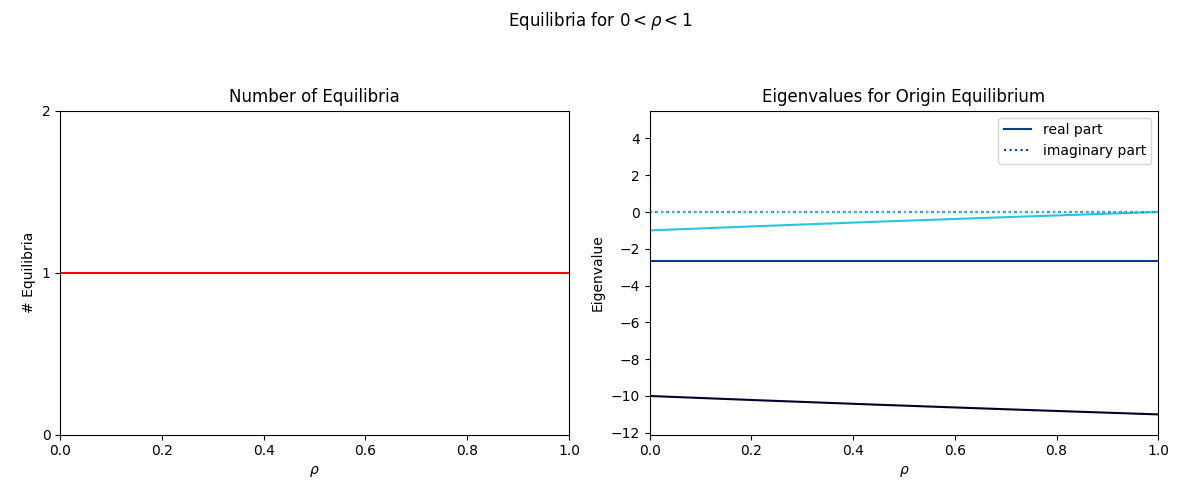

In [21]:
fig_q1, axs_q1 = plt.subplots(ncols=2, figsize=(12, 5))
plot_q1()
decorate_q1()

We find that, for $\rho < 1$, there exists only 1 equilibrium (left plot). From the introduction in the SOLUTION section, we know this is the origin $(0, 0, 0)$.

On the right, the 3 eigenvalues of the Jacobian matrix in this equilibrium are displayed (in different colors). We find that they're all real and less than 0, thus the origin is a stable equilibrium.

To illustrate this, a 3D plot of trajectories is shown below.

In [22]:
fig3D_q1, ax3D_q1 = plt.subplots(subplot_kw={'projection': '3d'})
plot3D_q1(config_q1['r'], config_q1['show_arrows'], config_q1['show_legend'])
decorate3D_q1()

HBox([
    VBox([q1_arrows_checkbox, q1_legend_checkbox]),
    VBox([q1_r_slider])
])

We show 4 trajectories with different initial positions: (1, 1, 1), (1, -1, -1), (-1, -1, 1) and (-1, -1, -1). Each trajectory converges to the origin, indicating its stability. This is true for all $\rho < 1$.

### Question 2

The figure below display the equilibria for $0.65 < \rho < 1.35$.

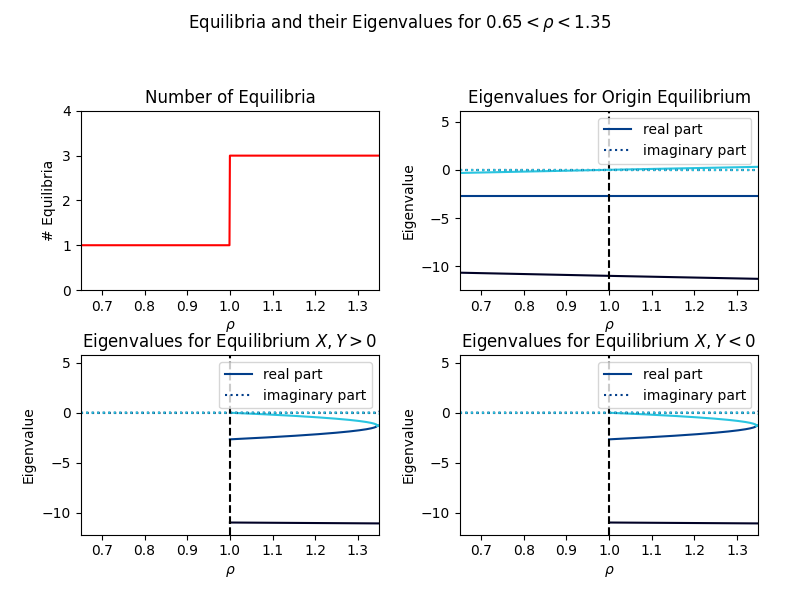

In [23]:
fig_eigenvals_q2, axs_eigenvals_q2 = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))
plot_eigenvals_q2()
decorate_eigenvals_q2()

The plot on the upper left shows the number of equilibria. We can see that at $\rho = 1$, two new equilibria emerge. From the introduction in the SOLUTION section, we know the form of these equilibria.

$(\sqrt{\beta (\rho - 1)}, \sqrt{\beta (\rho - 1)}, \rho - 1)$

$(-\sqrt{\beta (\rho - 1)}, -\sqrt{\beta (\rho - 1)}, \rho - 1)$

We see that for $\rho = 1$, these equilibria are equal to the $(0, 0, 0)$. These new equilibria thus emerge from the origin.

The other 3 plots show the eigenvalues for the 3 equilibria, where the *black dashed line* indicates the bifurcation. Indeed, the non-trivial equilibria don't have eigenvalues before this dotted line, since they don't exist. As before, all eigenvalues are real. For the non-trivial equilibria, we can further see that the eigenvalues are all less than 0, from which we deduce these new equilibria are both stable.

Notice however, that one eigenvalue for the origin equilibrium becomes positive for $\rho > 1$. This means that the origin becomes a saddle point at $\rho = 1$, which we label as unstable [10]. We can conclude that a **pitchfork bifurcation** takes place at $\rho = 1$ at the origin.

The figure below shows the bifurcation diagrams for $0.65 < \rho < 1.35$.

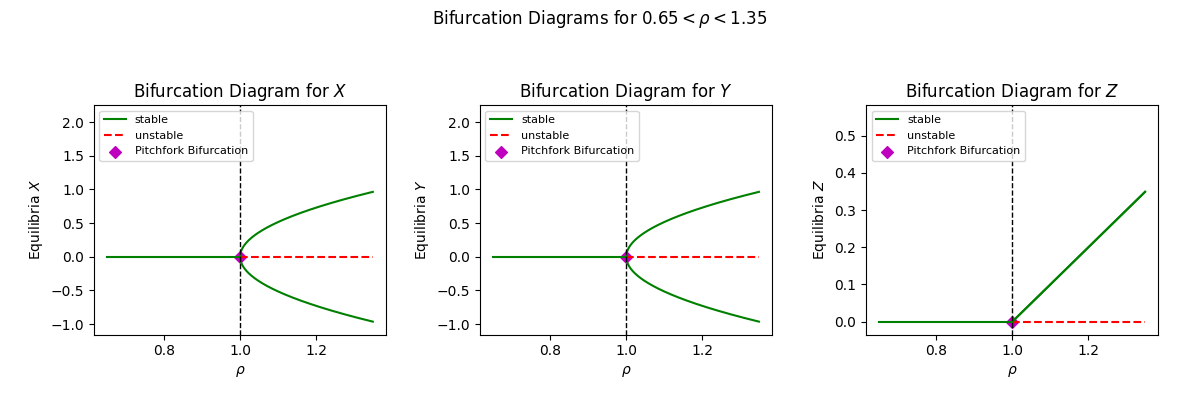

In [24]:
fig_bifurcations_q2, axs_bifurcations_q2 = plt.subplots(ncols=3, figsize=(12, 4))
plot_bifurcations_q2()
decorate_bifurcations_q2()

Indeed, we find the typical form of a pitchfork bifurcation for the left 2 plots, where the origin becomes unstable. Since the 2 non-trivial equilibria have the same $Z$ value, they coincide for the bifurcation diagram for $Z$.

To illustrate this behaviour, a 3D trajectory plot is shown below.

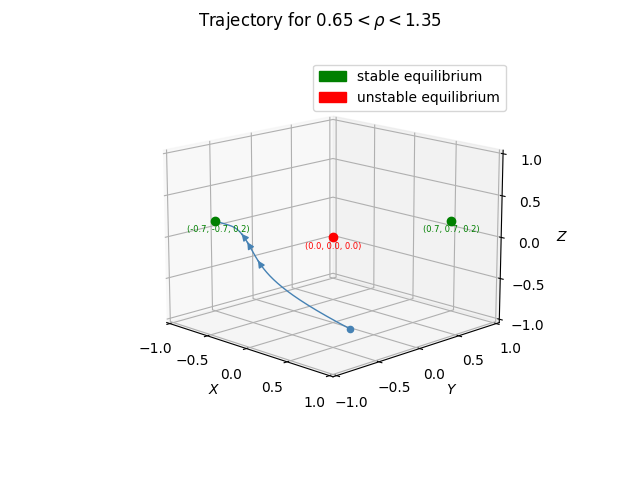

In [25]:
fig_traj_q2, ax_traj_q2 = plt.subplots(subplot_kw={'projection': '3d'})
plot_traj_q2(
    config_q2['ic'],
    config_q2['r'],
    config_q2['show_arrows'],
    config_q2['show_legend']
)
decorate_traj_q2()

HBox([
    VBox([q2_arrows_checkbox, q2_legend_checkbox]),
    VBox([q2_r_slider, q2_ic_button])
])

When $\rho$ is varied so it passes $1$, we can clearly see the 2 new equilibria emerging from the origin. The stability is further motivated by generating random starting points, and seeing that the trajectory converges to one of the non-trivial equilibria for $\rho > 1$.

### Question 3

The figure below displays the equilibria for $0 < \rho < 50$.


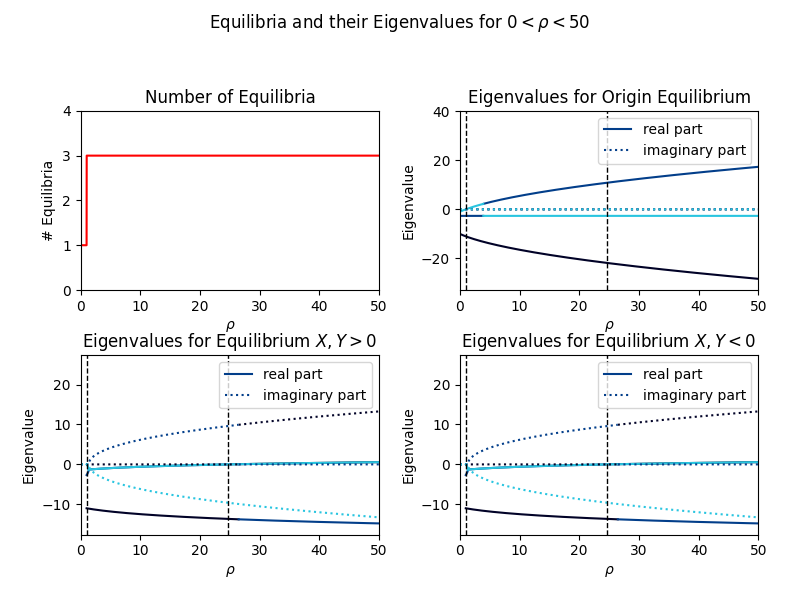

In [26]:
fig_eigenvals_q3, axs_eigenvals_q3 = plt.subplots(
    ncols=2, nrows=2, figsize=(8, 6)
)
plot_eigenvals_q3()
decorate_eigenvals_q3()

The plot on the upper left shows the number of equilibria. We can see that it remains constant for all $\rho > 1$, as can also be deducted from the introduction in the SOLUTION section.

Notice that for each non-trivial equilibrium, 2 eigenvalues merge into complex conjugates at $\rho = 1.35$. This means that trajectories will now have a spiral motion to them.

The *black dashed lines* again indicate the bifurcations. We can see that a second bifurcation happens at around $\rho = 24.74$, where the non-trivial equilibria also lose stability through a **Hopf Bifurcation** [11].

The figures below zoom in on the 2 bifurcations for the equilibrium $X, Y > 0$. (Alternatively, you can also zoom via jupyter widgets).

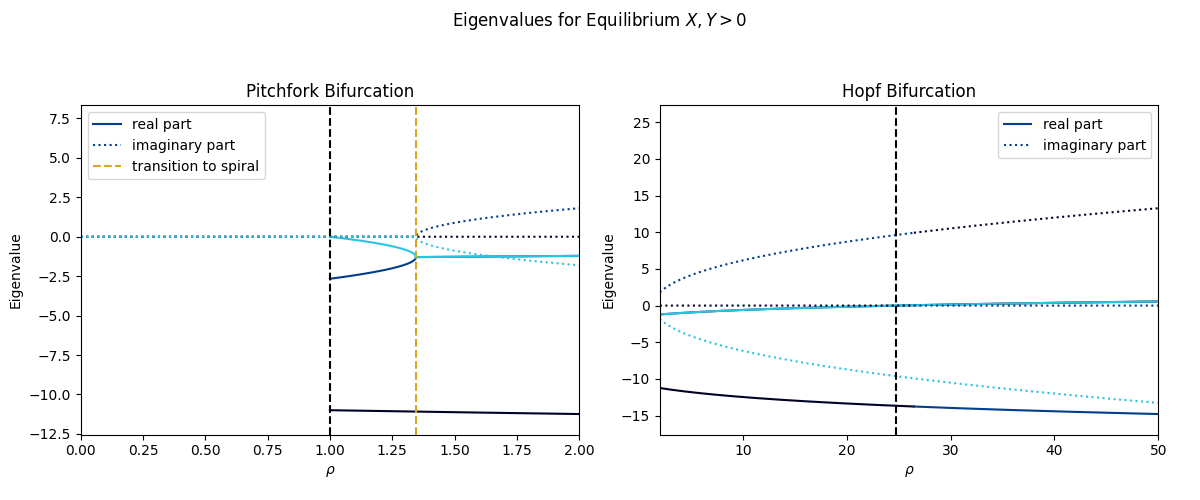

In [27]:
fig_eigenvals_pos_q3, axs_eigenvals_pos_q3 = plt.subplots(
    ncols=2, figsize=(12, 5)
)
plot_eigenvals_pos_q3()
decorate_eigenvals_pos_q3()

The left plot displays the pitchfork bifurcation we saw in **Question 2**. At $\rho = 1.35$, two eigenvalues become complex conjugates, indicating the presence of a stable spiral.

The right plot shows the Hopf bifurcation for $\rho = 24.74$. The real part of the pair of complex conjugates becomes positive, which means that the stable spiral becomes unstable.

The figure below displays the bifurcation diagrams for $0 < \rho < 50$.

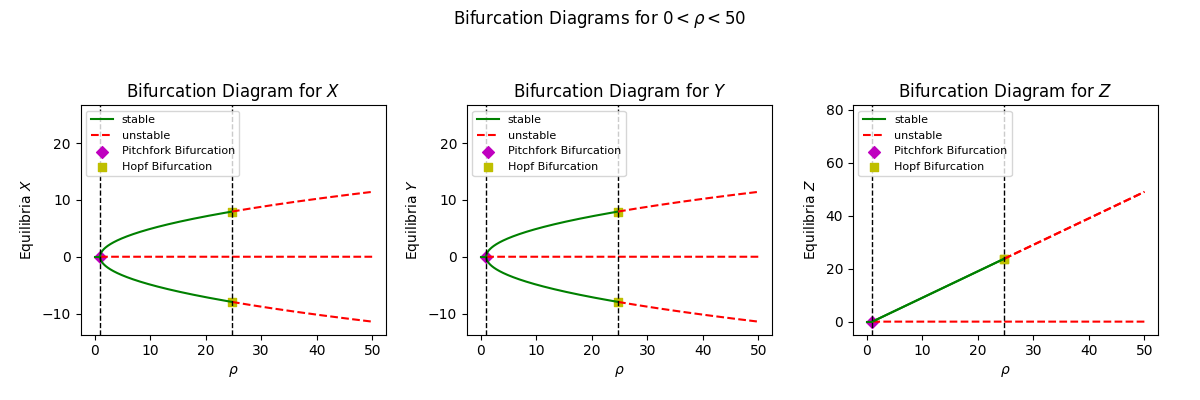

In [28]:
fig_bifurcations_q3, axs_bifurcations_q3 = plt.subplots(
    ncols=3, figsize=(12, 4)
)
plot_bifurcations_q3()
decorate_bifurcations_q3()

The figure below shows some trajectories for different $\rho$, in order to illustrate the behaviour of the equilibria. The initial point is $(0, 1, 0.5)$.

In [29]:
fig_slides_q3, axs_slides_q3 = plt.subplots(
    ncols=2, nrows=2, figsize=(8, 6), subplot_kw={'projection': '3d'}
)
plot_slides_q3()
decorate_slides_q3()

Indeed, for $\rho = 13, 14$ and $15$ we see that the non-trivial equilibria have stable spirals. For $\rho = 28$, the spirals are unstable and we observe the typical butterfly pattern of the Lorenz attractor.

In the figure below, you can experiment with different values for $\rho$. You can also generate random starting points [12].

In [30]:
fig_traj_q3, ax_traj_q3 = plt.subplots(subplot_kw={'projection': '3d'})
plot_traj_q3(
    config_q3['ic'],
    config_q3['r'],
    config_q3['show_arrows'],
    config_q3['show_legend']
)
decorate_traj_q3()

HBox([
    VBox([q3_arrows_checkbox, q3_legend_checkbox]),
    VBox([q3_r_slider, q3_ic_button])
])

### Question 4

The figure below shows the time evolution of $(X, Y, Z)$ for $\rho = 22.05$.

<IPython.core.display.Javascript object>

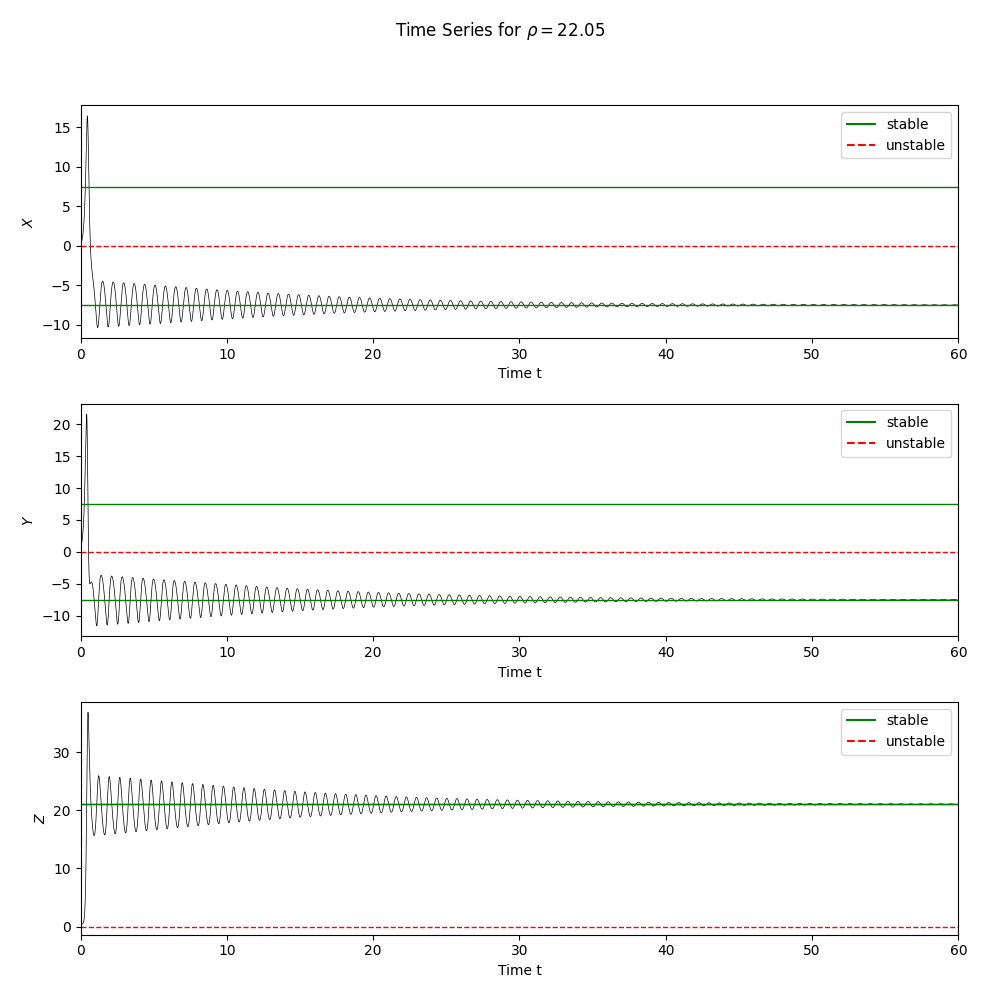

In [31]:
fig_timeseries_1_q4, axs_timeseries_1_q4 = plt.subplots(nrows=3, figsize=(10, 10))
plot_timeseries_1_q4(config_q4['ic1'])
decorate_timeseries_1_q4()

display(Javascript(
    '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''
))

HBox([q4_x1_slider, q4_y1_slider, q4_z1_slider])

You can see that, for every initial condition $(X_0, Y_0, Z_0)$, the system converges to one of the 2 equilibria (the distance to the equilibrium decreases over time, thus they are stable).

The figure below shows the time evolution of $(X, Y, Z)$ for $\rho = 25$.

<IPython.core.display.Javascript object>

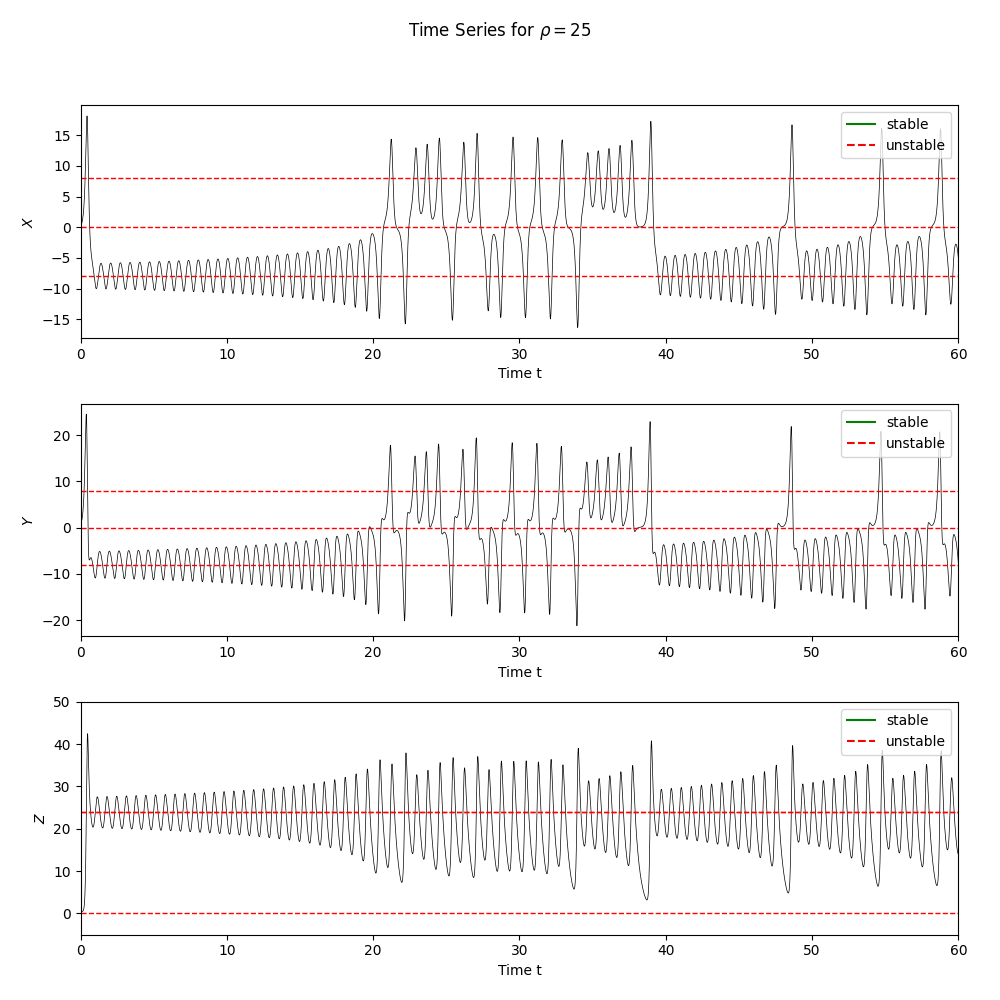

In [32]:
fig_timeseries_2_q4, axs_timeseries_2_q4 = plt.subplots(nrows=3, figsize=(10, 10))
plot_timeseries_2_q4(config_q4['ic2'])
decorate_timeseries_2_q4()

display(Javascript(
    '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''
))

HBox([q4_x2_slider, q4_y2_slider, q4_z2_slider])

As we know, since $\rho > 24.74$, all equilibria are unstable. Notice however, that the system appears to show periodic behaviour, but this also has some kind of randomness to it. In fact, the time series is non-repeating, and together with the complex trajectories observed in **Question 3**, this is a sign of a **chaotic attractor**. A more in depth analysis can be found in the EPILOGUE section.

### Question 5

The figure below shows $Z$ in function of $Y$ for $\rho = 24.06$. The initial condition is $(-12, -12, 20)$.

In [33]:
fig_traj_proj_q5, axs_traj_proj_q5 = plt.subplots(ncols=2, figsize=(12, 5))
plot_traj_proj_1_q5(config_q5['steps'])
plot_traj_proj_2_q5()
decorate_traj_proj_q5()

HBox([q5_time_slider, widgets.Label('(left plot only)')])

On the right plot, you can see that the trajectory has 2 regions or wings, around the 2 non-trivial equilibria. The plot on the left lets you vary the time. If you play a bit with this, you might notice that the trajectory stays on one wing for a long time. However, when a maximum $Z_n$ of $Z$ exceeds a certain threshold value called $Z_{crit}$, it switches wings.

To make this more rigorous, we do the following. Choose a wing, let's say the left wing. When we look at the maxima $Z_n$ of only the left wing, what can we say about the $Y$ value $Y_{n+1}$ of the next maximum? If it stays on the same wing, $Y_{n+1}$ stays in the same region at around $Y = -7$. If it switches to the right wing however, it suddenly jumps to around $Y = 7$.

The figure below displays $Y_{n+1}$ in function of $Z_n$, for both the left and right wing.

In [34]:
fig_z_max_to_y_q5, axs_z_max_to_y_q5 = plt.subplots(
    ncols=2, figsize=(12, 5)
)
plot_z_max_to_y_q5(config_q5['ic'])
decorate_z_max_to_y_q5()

HBox([q5_x_slider, q5_y_slider, q5_z_slider])

Indeed we can see that, when $Z_n$ exceeds $Z_{crit}$, the trajectory switches wings. This is also how $Z_{crit}$ was calculated (see **Numerical Computation** in the EPILOGUE section).

It is also important to remark that the non-trivial equilibria are still stable for $\rho = 24.06$. For more information, see **Chaos** under the EPILOGUE section.

### Question 6

The figure below shows the time evolution of $Z$ for $\rho = 24.06$, and the maxima $Z_n$.

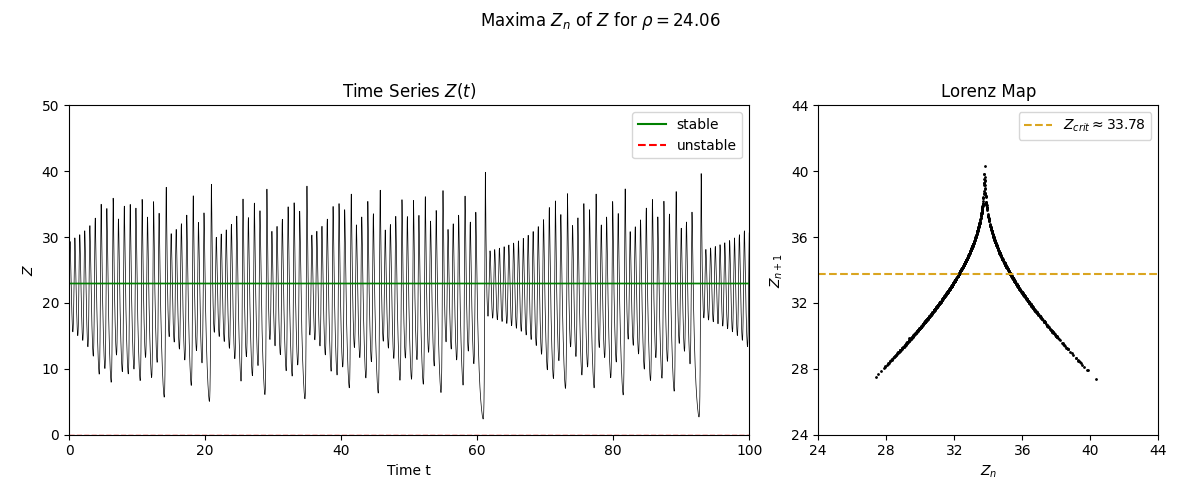

In [35]:
fig_lorenz_q6, axs_lorenz_q6 = plt.subplots(
    ncols=2, figsize=(12, 5), width_ratios=[2, 1]
)
plot_lorenz_q6(config_q6['ic'])
decorate_lorenz_q6()

HBox([q6_x_slider, q6_y_slider, q6_z_slider])

Since the maxima $Z_n$ gives an indication of what happens to the trajectory, $Z_n$ could be able to predict $Z_{n+1}$. The plot on the right shows exactly that, $Z_{n+1}$ in function of $Z_n$. This is known as a Lorenz map. Points above the *gold dashed line* correspond to the trajectory switching wings.

If the system behaved randomly, the points on the Lorenz map would be all over the place. They show order however, indicating the chaotic behaviour. It seems as if you could fit a function to this map [13], which means that indeed $Z_n$ predicts $Z_{n+1}$.

### Question 7

We show that the system is chaotic via the following figure.

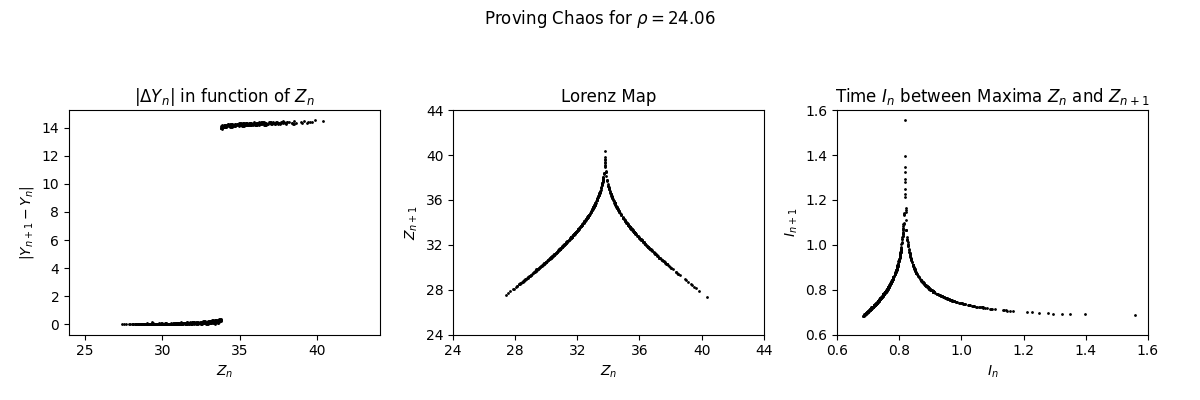

In [36]:
fig_chaos_q7, axs_chaos_q7 = plt.subplots(ncols=3, figsize=(12, 4))
plot_chaos_q7(config_q7['ic'], config_q7['steps'])
decorate_chaos_q7()

HBox([
    VBox([q7_x_slider, q7_y_slider, q7_z_slider]),
    VBox([q7_buttons, q7_buttons_label])
])

The plot on the left shows the displacement in $Y_n$ after a maximum $Z_n$. You could see this as combining the 2 plots from **Question 5**, where each $Y_n$ is subtracted from $Y_{n+1}$. We find that, for maxima $Z_n < Z_{crit}$, the wing doesn't switch, and for $Z_n > Z_{crit}$ it does switch (indicated by the large difference in $Y_n$). If the behaviour was random in stead of chaotic, these points would be all over the place.

The middle plot shows the Lorenz map. As indicated before, the plot shows order, which is a sign of chaotic behaviour.

The plot on the right measures the time difference $I_n$ between consecutive maxima $Z_n$ and $Z_{n+1}$ (this could be seen as the duration of the *active phase*, or the duration of a spiral around an equilibrium). $I_{n+1}$ is plotted in function of $I_n$, and again we observe order.

The figure below illustrates what happens in the plot on the right via the time series of $Z$.

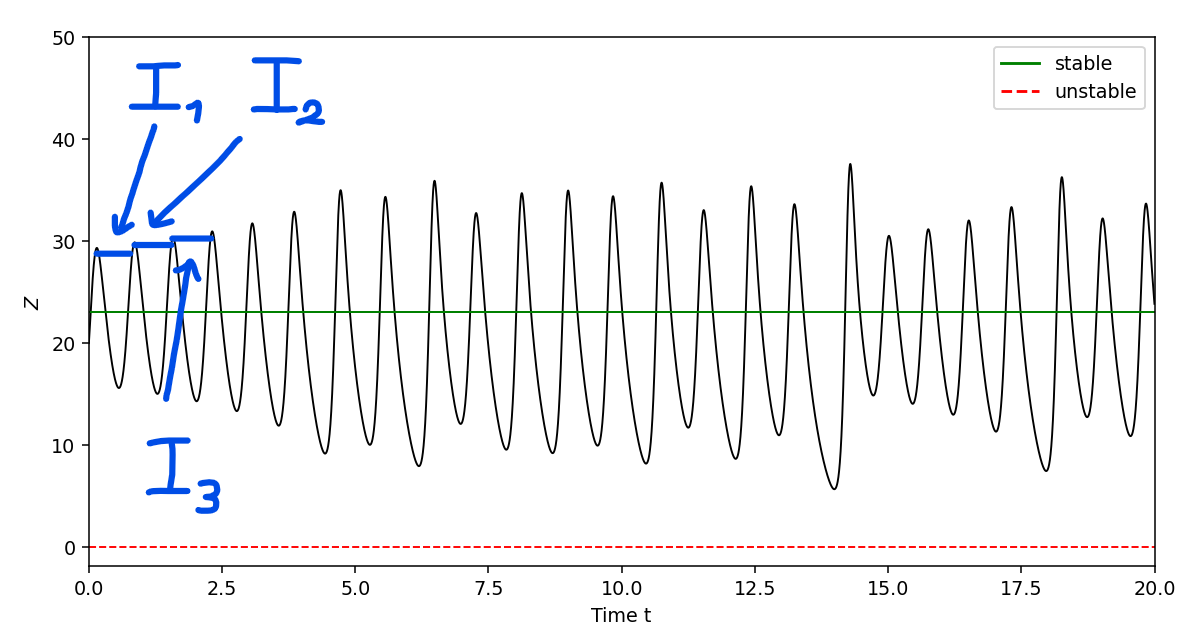

For more characteristics of chaotic behaviour, take a look at the **Chaos** subsection of the EPILOGUE.

## Epilogue

### Chaos

It is important to understand that, even though the behaviour of the Lorenz system seems random, it most certainly isn't. In fact, because you can write down precise differential equations, it is completely **deterministic**. Once you know the initial conditions, you can perfectly predict the time evolution of the system.

This is also where the caveat lies, since in practice it's impossible to measure the initial conditions with perfect accuracy. Sensitive dependence on initial conditions can lead to a very unexpected outcome some moment later in time. This is one of the **characteristics of chaotic behaviour** we will analyse in this subsection.

TRISTABILITY

---

There exists a small region $24.06 < \rho < 24.74$ for which a chaotic attractor coexists with 2 stable equilibria [14]. Because of this, the system can show chaotic behaviour, but not necessarily. If an initial point is picked close to a stable equilibrium, it indeed converges to that equilibrium. This is shown in the figure below.

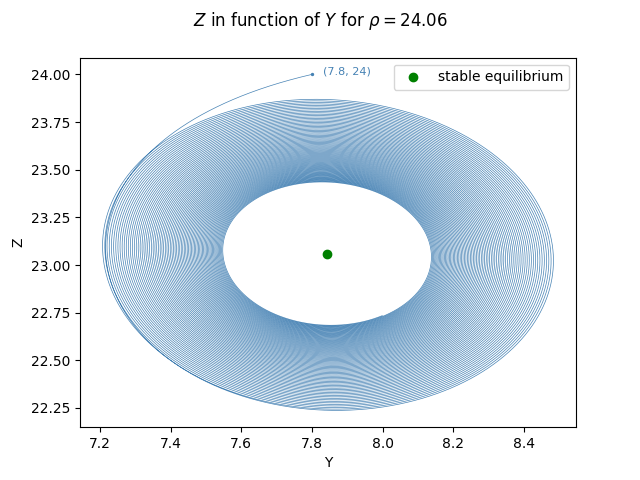

In [37]:
fig8, ax8 = plt.subplots()
epi8()

This looks a lot different from the first figure in **Question 5** from the ANSWERS section, where the initial point is $(-12, -12, 20)$.

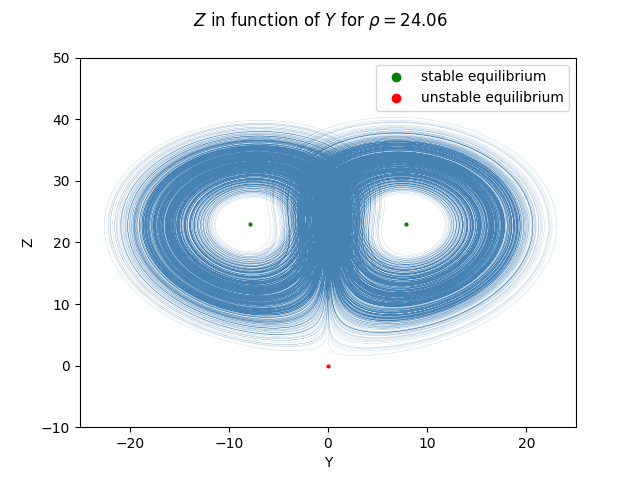

In [38]:
fig10, ax10 = plt.subplots()
epi10()

In fact, there are certain **basins of attraction** for these 3 attractors [15]. The figure below depicts a cross section ($Z = 23.4$ for $\rho = 24.4$) of the 3 attractors (black), where the dots indicate the stable equilibrium points and the curves a slice of the chaotic attractor. The basins for the point attractors are colored green and yellow, while the blue basin corresponds to that of the chaotic attractor.

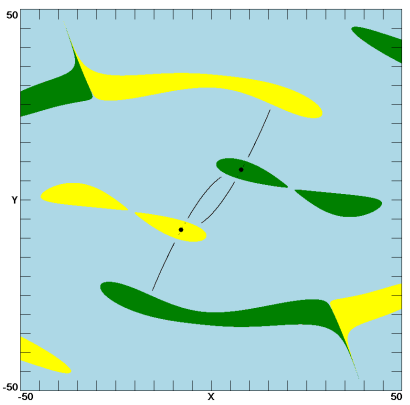

As of right now, there is no general method to determine the shape of these complex 3D shapes. In this paper: [3D Printing — The Basins of Tristability in the Lorenz System](https://sprott.physics.wisc.edu/pubs/paper477.pdf) by Anda Xiong and Julien C. Sprott, they tested around 5 million points numerically. Those that lie in the basin for one of the point attractors were indicated in blue, to give a sense of the shape of the basin. This is shown in the following figure.

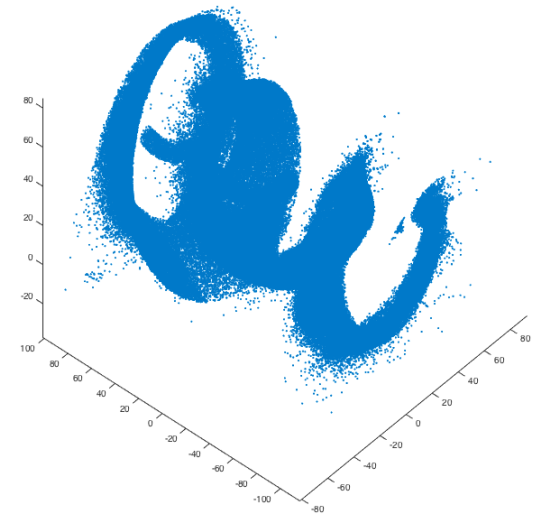

SENSITIVE DEPENDENCE ON INITIAL CONDITIONS

---

The figure below displays 2 trajectories whose initial positions differ by $10^{-10}$.

The plot on the left shows the trajectories at time $t = 25$. The 2 trajectories still seem to overlap.

The plot on the right shows the trajectories at time $t = 200$. It is now clear that the 2 trajectories are different. Even a difference in the initial position as small as $10^{-10}$ has a large impact on the trajectory at a much later time. This is characteristic to chaotic behaviour.

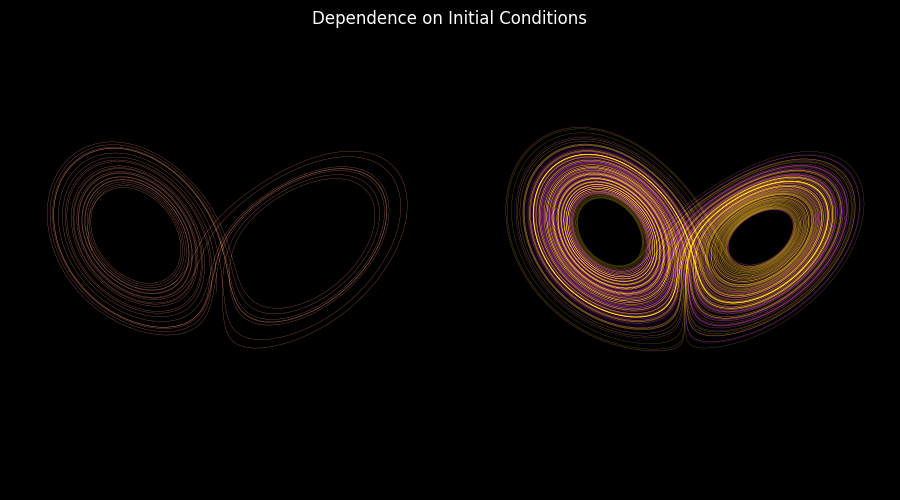

In [39]:
fig9, axs9 = plt.subplots(
    subplot_kw={'projection': '3d'}, ncols=2, figsize=(9, 5)
)
epi9()

LORENZ MAP

---

It shouldn't come as a surprise that for $\rho = 24.06$ the system shows chaotic behaviour. The Lorenz map, which plots $Z_{n+1}$ in function of $Z_n$ kind of resembles a tent map (right plot), where $x_{k+1} = f(x_k) = 2 \cdot min(x_k, 1 - x_k)$.

In [40]:
fig11, axs11 = plt.subplots(ncols=2, figsize=(10, 5))
epi11()

The tent map is discrete time system, which is known to show chaotic behaviour [16]. The figure below displays a trajectory in red for a duration of $t = 100$, where $x_0 = 0.33$.

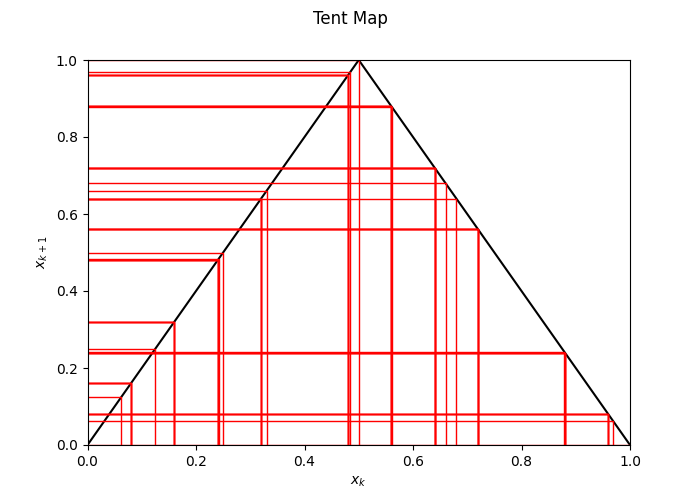

In [48]:
fig12, ax12 = plt.subplots(figsize=(7, 5))
epi12(0.33, 100)

### Numerical Computation

The computation of $Z_{crit}$ happened via the function *calculate_z_crit*. Based on the function *get_z_max_to_next_y* which was plotted in **Question 5** in the ANSWERS section, this function takes in a specific wing. It also takes in a cuboid whose borders are defined by *xint, yint* and *zint*, from which to sample initial positions. The amount of samples per axis is specified via *axis_samples*. (Be careful though, as the computational cost grows with an exponent of $3$, *axis_samples* $= 2$ samples all 8 corners of the cuboid for example).

The function calculates the position of the jump in $Y_{n+1}$ for all initial values, and returns the average.

In [42]:
def calculate_z_crit(wing, r, dt, steps, xint, yint, zint, axis_samples=2):
    X_samples = np.linspace(*xint, axis_samples)
    Y_samples = np.linspace(*yint, axis_samples)
    Z_samples = np.linspace(*zint, axis_samples)

    Z_crit = []

    for x in X_samples:
        for y in Y_samples:
            for z in Z_samples:
                _, _, Y, Z = get_trajectory(x, y, z, r, dt, steps)
                Z_prev, Y_next = get_z_max_to_y(Z, Y, wing)

                if wing == 'left':
                    func_neg = np.max
                    func_pos = np.min

                else:
                    func_neg = np.min
                    func_pos = np.max

                z_neg = func_neg(Z_prev[Y_next < 0])
                z_pos = func_pos(Z_prev[Y_next > 0])
                Z_crit.extend([z_neg, z_pos])

    return np.average(Z_crit)

This is the code with which *Z_CRIT* was calculated. The value of *Z_CRIT* is the same for both wings.

In [43]:
'''

Z_CRIT_LEFT = calculate_z_crit(
    'left', 24.06, 0.001, 10000000,
    [-1, 1], [-1, 1], [-1, 1], axis_samples=2
)

Z_CRIT_RIGHT = calculate_z_crit(
    'right', 24.06, 0.001, 10000000,
    [-1, 1], [-1, 1], [-1, 1], axis_samples=2
)

print(f'critical z for left wing: {Z_CRIT_LEFT}')
print(f'critical z for right wing: {Z_CRIT_RIGHT}')

'''

"\n\nZ_CRIT_LEFT = calculate_z_crit(\n    'left', 24.06, 0.001, 10000000,\n    [-1, 1], [-1, 1], [-1, 1], axis_samples=2\n)\n\nZ_CRIT_RIGHT = calculate_z_crit(\n    'right', 24.06, 0.001, 10000000,\n    [-1, 1], [-1, 1], [-1, 1], axis_samples=2\n)\n\nprint(f'critical z for left wing: {Z_CRIT_LEFT}')\nprint(f'critical z for right wing: {Z_CRIT_RIGHT}')\n\n"

## Notes

[0] This is an example note.

---

[1] [WetHat/PY-Drawing3D.ipynb](https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c)

---

[2] The values for $\rho$ at which bifurcations occur, were calculated as followed (For this, you need to have gone through the first half of the ANSWERS section).

PITCHFORK BIFURCATION

We know the form of the equilibria.

$(0, 0, 0)$

$(\sqrt{\beta (\rho - 1)}, \sqrt{\beta (\rho - 1)}, \rho - 1)$

$(-\sqrt{\beta (\rho - 1)}, -\sqrt{\beta (\rho - 1)}, \rho - 1)$

The last 2 are only defined on the reals for $\rho \ge 1$, and we know that for $\rho = 1$ they are equal to $(0, 0, 0)$. We know via the eigenvalues of the Jacobian matrix, that the origin becomes unstable and that the 2 new equilibria are both stable. This is thus a pitchfork bifurcation for $\rho = 1$.

HOPF BIFURCATION

The eigenvalues are the roots of the characteristic polynomial of the Jacobian matrix.

$k_{\mathsf{J}}(\lambda) = \lambda^3 + [\sigma + \beta + 1]\lambda^2 + [\beta + X^2 + \sigma(Z - \rho + 1 + \beta)]\lambda + \sigma[X(X + Y) + \beta(Z - \rho + 1)]$

Plugging in $(X, Y, Z) = (\pm \sqrt{\beta (\rho - 1)}, \pm \sqrt{\beta (\rho - 1)}, \rho - 1)$ gives:

$k_{\mathsf{J}}(\lambda) = \lambda^3 + (\sigma + \beta + 1)\lambda^2 + \beta(\sigma + \rho)\lambda + 2\beta \sigma (\rho - 1) = 0$

The equilibria become unstable when the $\mathrm{Re}(\lambda) > 0$. At the point $\rho_H$ of the bifurcation, the $\mathrm{Re}(\lambda) = 0$. Plugging in a purely imaginary $\lambda = i\mu$ with $\mu \in \mathbb{R}$:

$k_{\mathsf{J}}(i\mu) = -i\mu^3 - (\sigma + \beta + 1)\mu^2 + i\beta(\sigma + \rho)\mu + 2\beta \sigma (\rho - 1) = 0$

Both the real and imaginary part of $k_{\mathsf{J}}(i\mu)$ must vanish:

$(\sigma + \beta + 1)\mu^2 = 2\beta \sigma (\rho - 1)$

$\mu^3 = \beta(\sigma + \rho)\mu$

Thus, since $\mu \neq 0$:

$\rho_H = \sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$

---

[3] See **Question 5** in the ANSWERS section. This value was calculated numerically. You can find more information in the EPILOGUE section, under **Numerical Computation**.

---

[4] The *get_equilibria* function returns 3 matrices of complex equilibria. To do so, the parameter $\rho$ should also be complex. Equilibria which are not purely real are filtered out in the *get_real_equilibria* function.

The *get_equilibria* function was written in the way it is, so arrays of equilibria *X, Y, Z* of same size are returned. Although these complex equilibria are not specifically needed, it is good practice to work with complex numbers (opposed to *np.nan* for example).

---

[5] The coefficients of the characteristic polynomial were calculated by hand, so that *get_eigenvals* only has to calculate the roots (via *np.roots*). This is faster than using the sympy library to calculate the Jacobian matrix and its eigenvalues, for example.

---

[6] See **Question 5** in the ANSWERS section. The function *get_z_max_to_y* takes in $Z$ in function of $Y$, and a wing (left or right). It calculates the local maxima $Z_n$ of $Z$ and the values of $Y$ at those maxima, called $Y_n$. It then only looks at the maxima $Z_k$ of a given wing, and returns the values $Y_{k + 1}$.

There exist 2 regions around the 2 non-trivial equilibria. If $Z(Y)$ doesn't switch wings, $Y_{k + 1}$ will stay in the same region. If it does, then $Y_{k + 1}$ switches regions.

---

[7] The *segmented* function cuts the array of $\rho$ values at the bifurcations, and returns the segments of the arrays of equilibria. This is used in the *plot_bifurcation* function.

---

[8] The **Plot Decoration** subsection of SOLUTION sometimes sets borders of plots explicitly. Changing these values might not always have an impact on figures, although it's unlikely it breaks stuff.

---

[9] The **Plot Decoration** subsection of SOLUTION violates an important rule for code readability stated in the [PEP 8 - Style Guide for Python](https://peps.python.org/pep-0008/#:~:text=spaces%20for%20indentation.-,Maximum%20Line%20Length,be%20limited%20to%2072%20characters.), by exceeding the maximum line length of 79 characters. However, this choice was made intentionally for setting suptitles on *matplotlib.pyplot* Figures and titles on *matplotlib.pyplot* Axes. We'd argue this is more readable than wrapping the text.

---

[10] Note that, although 2 eigenvalues are still negative, the origin becomes unstable. The eigenspaces of those 2 eigenvalues form a 2D subspace, and if the initial point $(X_0, Y_0, Z_0)$ happens to lie in this subspace, it would indeed converge to the origin. This never happens in real life, since the probability of the initial point lying in this subspace is 0. Every other initial condition would grow away from the origin. It thus is correct to say the equilibrium is unstable.

---

[11] The stable spirals from the non-trivial equilibria become unstable at $\rho = 24.74$. Although we characterise Hopf bifurcations by losing stability and creation of a limit cycle, some sources call this bifurcation in the Lorenz system also a Hopf bifurcation [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system), [Strogatz, Nonlinear Dynamics and Chaos](https://www.biodyn.ro/course/literatura/Nonlinear_Dynamics_and_Chaos_2018_Steven_H._Strogatz.pdf) p. 338. It is very important to note that there is no limit cycle here, although a strange attractor does appear at $\rho = 24.06$.

---

[12] Like in **Question 2** of the ANSWERS section, these starting points are random in the sense that they are chosen at random on a sphere with some radius and some noise on that radius. The radius is small so that the trajectory does not exceed the bounds of the plot.

---

[13] There is however some thickness to the graph, meaning that a well defined function mapping $Z_n$ to $Z_{n+1}$ does not exist.

---

[14] [Strogatz, Nonlinear Dynamics and Chaos](https://www.biodyn.ro/course/literatura/Nonlinear_Dynamics_and_Chaos_2018_Steven_H._Strogatz.pdf) p. 338, [3D Printing — The Basins of Tristability in the Lorenz System](https://sprott.physics.wisc.edu/pubs/paper477.pdf), Yorke and Yorke 1979.

---

[15] [3D Printing — The Basins of Tristability in the Lorenz System](https://sprott.physics.wisc.edu/pubs/paper477.pdf). This goes beyond the scope of this assignment.

---

[16] [Tent map](https://en.wikipedia.org/wiki/Tent_map)